# Emotion Prediction Model Pipeline

This notebook provides a comprehensive implementation of the emotion prediction pipeline from data loading through model training to visualization. The notebook replicates the entire workflow implemented in the Sentio codebase.

## Overview

The pipeline includes:
1. Data loading and preprocessing
2. Feature aggregation and scaling
3. Model training (Ridge, SVR, XGBoost)
4. Model evaluation and comparison
5. Ensemble model creation
6. Visualization on the valence-arousal plane

**Date:** September 17, 2025
**Author:** Emotion Prediction Pipeline

In [24]:
# Import Required Libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')

# Add src to path to import custom modules
sys.path.append('../src')

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 11

print("✅ Libraries imported successfully!")
print(f"Current working directory: {os.getcwd()}")
print("Ready to start the emotion prediction pipeline!")

✅ Libraries imported successfully!
Current working directory: /mnt/sdb8mount/free-explore/class/ai/datasets/sentio/notebooks
Ready to start the emotion prediction pipeline!


In [25]:
# Configuration and setup
import os

# Configuration
CONFIG = {
    # Updated paths to be relative from notebooks directory
    'annotations_path_1': '../dataset/DEAM/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv',
    'annotations_path_2': '../dataset/DEAM/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_2000_2058.csv',
    'features_dir': '../selected',
    'output_dir': '../notebook_output',
    'emotion_dimensions': ['valence', 'arousal'],
    'test_size': 0.2,
    'random_state': 42
}

# Display configuration
print("📁 Annotations path 1:", CONFIG['annotations_path_1'])
print("📁 Annotations path 2:", CONFIG['annotations_path_2'])
print("📁 Features directory:", CONFIG['features_dir'])
print("📁 Output directory:", CONFIG['output_dir'])
print("🎯 Emotion dimensions:", CONFIG['emotion_dimensions'])

# Verify paths exist
print("\n🔍 Path verification:")
print("✅ Annotations 1:" if os.path.exists(CONFIG['annotations_path_1']) else "❌ Annotations 1:", CONFIG['annotations_path_1'])
print("✅ Annotations 2:" if os.path.exists(CONFIG['annotations_path_2']) else "❌ Annotations 2:", CONFIG['annotations_path_2'])
print("✅ Features directory:" if os.path.exists(CONFIG['features_dir']) else "❌ Features directory:", CONFIG['features_dir'])
print("🎯 Configuration complete!")

📁 Annotations path 1: ../dataset/DEAM/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv
📁 Annotations path 2: ../dataset/DEAM/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_2000_2058.csv
📁 Features directory: ../selected
📁 Output directory: ../notebook_output
🎯 Emotion dimensions: ['valence', 'arousal']

🔍 Path verification:
✅ Annotations 1: ../dataset/DEAM/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv
✅ Annotations 2: ../dataset/DEAM/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_2000_2058.csv
✅ Features directory: ../selected
🎯 Configuration complete!


In [26]:
# Data exploration and verification
import pandas as pd
import glob

def load_annotations():
    """Load and combine both annotation files"""
    try:
        # Load both annotation files
        annotations_1 = pd.read_csv(CONFIG['annotations_path_1'])
        annotations_2 = pd.read_csv(CONFIG['annotations_path_2'])
        
        # Combine them
        annotations = pd.concat([annotations_1, annotations_2], ignore_index=True)
        
        print(f"✅ Successfully loaded annotations:")
        print(f"   - File 1: {len(annotations_1)} songs")
        print(f"   - File 2: {len(annotations_2)} songs")
        print(f"   - Total: {len(annotations)} songs")
        
        return annotations
        
    except Exception as e:
        print(f"Error loading annotations: {e}")
        # Create sample data for testing
        return pd.DataFrame({
            'song_id': range(1, 11),
            'valence': np.random.uniform(-1, 1, 10),
            'arousal': np.random.uniform(-1, 1, 10)
        })

def explore_features():
    """Explore available feature files"""
    feature_files = glob.glob(os.path.join(CONFIG['features_dir'], '*.csv'))
    print(f"🎵 Found {len(feature_files)} feature files")
    
    if feature_files:
        # Sample a feature file to understand structure
        sample_file = feature_files[0]
        sample_features = pd.read_csv(sample_file)
        print(f"📋 Feature file structure (sample: {os.path.basename(sample_file)}):")
        print(f"   - Shape: {sample_features.shape}")
        print(f"   - Columns: {list(sample_features.columns)}")
    
    return feature_files

# Load and explore data
annotations = load_annotations()
feature_files = explore_features()

print("\n📊 Sample annotations:")
annotations.head(10)

✅ Successfully loaded annotations:
   - File 1: 1744 songs
   - File 2: 58 songs
   - Total: 1802 songs
🎵 Found 1802 feature files
📋 Feature file structure (sample: 1269_selected.csv):
   - Shape: (88, 41)
   - Columns: ['frameTime', 'F0final_sma_stddev', 'F0final_sma_amean', 'F0final_sma_de_stddev', 'F0final_sma_de_amean', 'pcm_RMSenergy_sma_stddev', 'pcm_RMSenergy_sma_amean', 'pcm_RMSenergy_sma_de_stddev', 'pcm_RMSenergy_sma_de_amean', 'pcm_fftMag_spectralRollOff75.0_sma_stddev', 'pcm_fftMag_spectralRollOff75.0_sma_amean', 'pcm_fftMag_spectralRollOff90.0_sma_stddev', 'pcm_fftMag_spectralRollOff90.0_sma_amean', 'pcm_fftMag_spectralRollOff75.0_sma_de_stddev', 'pcm_fftMag_spectralRollOff75.0_sma_de_amean', 'pcm_fftMag_spectralRollOff90.0_sma_de_stddev', 'pcm_fftMag_spectralRollOff90.0_sma_de_amean', 'pcm_fftMag_spectralFlux_sma_stddev', 'pcm_fftMag_spectralFlux_sma_amean', 'pcm_fftMag_spectralFlux_sma_de_stddev', 'pcm_fftMag_spectralFlux_sma_de_amean', 'pcm_fftMag_spectralCentroid_sma_s

,song_id,valence_mean,valence_std,arousal_mean,arousal_std,valence_ max_mean,valence_max_std,valence_min_mean,valence_min_std,arousal_max_mean,arousal_max_std,arousal_min_mean,arousal_min_std
0,2,3.1,0.94,3.0,0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,3.5,1.75,3.3,1.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,5.7,1.42,5.5,1.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,4.4,2.01,5.3,1.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,5.8,1.47,6.4,1.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,8,3.2,1.40,4.8,1.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10,4.0,1.67,4.7,1.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,12,5.5,1.91,5.8,1.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,13,3.2,1.40,4.0,1.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,17,4.4,1.80,6.0,2.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Explore Feature Files
def explore_feature_files(features_dir):
    """Explore the feature files in the selected directory."""
    feature_files = glob.glob(os.path.join(features_dir, "*_selected.csv"))
    print(f"🔍 Found {len(feature_files)} feature files in {features_dir}")
    
    if feature_files:
        # Examine the first file
        sample_file = feature_files[0]
        sample_df = pd.read_csv(sample_file)
        
        print(f"\n📄 Sample file: {os.path.basename(sample_file)}")
        print(f"📊 Shape: {sample_df.shape}")
        print(f"📋 Features: {sample_df.shape[1] - 1} (excluding frameTime)")
        
        # Show first few column names (excluding frameTime)
        feature_cols = [col for col in sample_df.columns if col != 'frameTime']
        print(f"\n🎵 First 10 feature columns:")
        for i, col in enumerate(feature_cols[:10]):
            print(f"  {i+1:2d}. {col}")
        
        if len(feature_cols) > 10:
            print(f"  ... and {len(feature_cols) - 10} more features")
        
        return feature_files, sample_df
    
    print("❌ No feature files found!")
    return [], None

# Explore features using the correct directory
feature_files, sample_features_df = explore_feature_files(CONFIG['features_dir'])

if sample_features_df is not None:
    print(f"\n📈 Sample data from first feature file:")
    print(f"frameTime range: {sample_features_df['frameTime'].min():.2f} - {sample_features_df['frameTime'].max():.2f}")
    print(f"Number of time frames: {len(sample_features_df)}")
else:
    print("❌ Unable to load sample features")

🔍 Found 1802 feature files in ../selected

📄 Sample file: 1269_selected.csv
📊 Shape: (88, 41)
📋 Features: 40 (excluding frameTime)

🎵 First 10 feature columns:
   1. F0final_sma_stddev
   2. F0final_sma_amean
   3. F0final_sma_de_stddev
   4. F0final_sma_de_amean
   5. pcm_RMSenergy_sma_stddev
   6. pcm_RMSenergy_sma_amean
   7. pcm_RMSenergy_sma_de_stddev
   8. pcm_RMSenergy_sma_de_amean
   9. pcm_fftMag_spectralRollOff75.0_sma_stddev
  10. pcm_fftMag_spectralRollOff75.0_sma_amean
  ... and 30 more features

📈 Sample data from first feature file:
frameTime range: 0.00 - 43.50
Number of time frames: 88


In [28]:
# Fixed Feature Loading Function (40 Features Only)
def load_features(file_path):
    """
    Load features from a selected CSV file without additional aggregation.
    Each selected file already contains the 40 features we want to use.
    This will give us exactly 40 features instead of 160.
    """
    df = pd.read_csv(file_path)
    song_id = int(os.path.basename(file_path).split('_')[0])  # Convert to int to match annotations
    
    # Get all feature columns (skip frameTime)
    feature_cols = [col for col in df.columns if col != 'frameTime']
    
    # Create a single-row dataframe with the mean features across all time frames
    # This gives us exactly 40 features (one per original feature column)
    features_dict = {}
    for col in feature_cols:
        features_dict[col] = df[col].mean()  # Take mean across all time frames
    
    # Create dataframe with the features
    features_df = pd.DataFrame([features_dict])
    features_df['song_id'] = song_id  # Add song_id column
    
    return features_df

# Test the improved feature loading function on a sample file
if feature_files:
    sample_path = feature_files[0]
    sample_agg = load_features(sample_path)
    
    print(f"🔄 FIXED Feature loading test:")
    print(f"Original shape: {sample_features_df.shape} → Processed shape: {sample_agg.shape}")
    print(f"Original features: {sample_features_df.shape[1] - 1} → Final features: {sample_agg.shape[1] - 1}")
    print(f"✅ Now using exactly {sample_agg.shape[1] - 1} features (instead of 160)!")
    print(f"Song ID: {sample_agg['song_id'].iloc[0]} (type: {type(sample_agg['song_id'].iloc[0])})")
    
    # Show first few feature names to confirm we have the original 40 features
    feature_sample = [col for col in sample_agg.columns if col != 'song_id'][:5]
    print(f"\n📊 Sample feature names (first 5):")
    for i, col in enumerate(feature_sample):
        print(f"  {i+1:2d}. {col}: {sample_agg[col].iloc[0]:.4f}")
    
    print(f"\n🎯 Total feature columns: {len([col for col in sample_agg.columns if col != 'song_id'])}")
else:
    print("⚠️ No feature files available for testing")

🔄 FIXED Feature loading test:
Original shape: (88, 41) → Processed shape: (1, 41)
Original features: 40 → Final features: 40
✅ Now using exactly 40 features (instead of 160)!
Song ID: 1269 (type: <class 'numpy.int64'>)

📊 Sample feature names (first 5):
   1. F0final_sma_stddev: 53.2437
   2. F0final_sma_amean: 160.9188
   3. F0final_sma_de_stddev: 0.0052
   4. F0final_sma_de_amean: 0.0000
   5. pcm_RMSenergy_sma_stddev: 0.0211

🎯 Total feature columns: 40


In [29]:
# Fixed: Process ALL feature files and create the complete dataset
def process_all_features(feature_files, annotations, max_files=None):
    """
    Process feature files and correctly match them with annotations.
    Fixed version that properly handles song ID matching and uses 40 features.
    """
    print("🚀 Starting FIXED dataset processing...")
    
    if max_files:
        feature_files = feature_files[:max_files]
        print(f"🔄 Processing {len(feature_files)} feature files (limited)...")
    else:
        print(f"📊 Processing ALL {len(feature_files)} feature files...")
    
    # Extract song IDs from annotation file for reference
    annotation_ids = set(annotations['song_id'].values)
    print(f"Found {len(annotation_ids)} unique song IDs in annotations")
    
    processed_features = []
    matched_ids = set()
    failed_files = []
    
    print("📈 Progress updates every 50 files...")
    
    for i, file_path in enumerate(feature_files):
        try:
            # Extract song ID from filename
            filename = os.path.basename(file_path)
            song_id = int(filename.split('_')[0])
            
            # Only process if song ID exists in annotations
            if song_id in annotation_ids:
                matched_ids.add(song_id)
                
                # Show progress
                if i < 10 or (i + 1) % 50 == 0 or (i + 1) == len(feature_files):
                    progress = (i + 1) / len(feature_files) * 100
                    print(f"  ⚡ Processing file {i+1}/{len(feature_files)} ({progress:.1f}%): {filename}")
                
                # Load features (using the new fixed function)
                features_df = load_features(file_path)
                processed_features.append(features_df)
            
        except Exception as e:
            failed_files.append((file_path, str(e)))
            print(f"  ❌ Failed to process {filename}: {str(e)}")
    
    print(f"\n📊 Processing Summary:")
    print(f"  ✅ Successfully processed: {len(processed_features)} files")
    print(f"  🔗 Songs matched with annotations: {len(matched_ids)} out of {len(annotation_ids)}")
    print(f"  ❌ Failed to process: {len(failed_files)} files")
    
    if not processed_features:
        print("❌ No features were processed successfully!")
        return None
        
    # Combine all processed features
    print("🔗 Combining processed features...")
    combined_features = pd.concat(processed_features, ignore_index=True)
    print(f"📊 Combined features shape: {combined_features.shape}")
    
    # Ensure we're using the correct column names in annotations
    annotations_clean = annotations.copy()
    annotations_clean.columns = [col.strip() for col in annotations_clean.columns]
    
    # Correctly transform the emotion values
    emotion_cols = ['song_id']
    if 'valence_mean' in annotations_clean.columns:
        emotion_cols.extend(['valence_mean', 'arousal_mean'])
        emotion_data = annotations_clean[emotion_cols].copy()
        # Scale from [1,9] to [-1,1]
        emotion_data['valence'] = (emotion_data['valence_mean'] - 5) / 4
        emotion_data['arousal'] = (emotion_data['arousal_mean'] - 5) / 4
    else:
        emotion_cols.extend(['valence', 'arousal'])
        emotion_data = annotations_clean[emotion_cols].copy()
        
    print("🔗 Merging features with annotations...")
    # Merge features with emotions
    dataset = pd.merge(combined_features, 
                      emotion_data[['song_id', 'valence', 'arousal']], 
                      on='song_id', how='inner')
    
    print(f"🎯 Final dataset: {len(dataset)} songs with features and annotations")
    
    if len(dataset) == 0:
        print("❌ No songs matched between features and annotations!")
        # Debug information
        feature_ids = set(combined_features['song_id'].unique())
        annotation_ids = set(emotion_data['song_id'].unique())
        print(f"Feature song IDs range: {min(feature_ids) if feature_ids else 'None'} - {max(feature_ids) if feature_ids else 'None'}")
        print(f"Annotation song IDs range: {min(annotation_ids) if annotation_ids else 'None'} - {max(annotation_ids) if annotation_ids else 'None'}")
        print(f"Sample feature IDs: {sorted(list(feature_ids))[:10]}")
        print(f"Sample annotation IDs: {sorted(list(annotation_ids))[:10]}")
        return None
    
    print(f"\n📈 Final dataset statistics:")
    print(f"Shape: {dataset.shape}")
    print(f"Features: {dataset.shape[1] - 3} (excluding song_id, valence, arousal)")
    print(f"✅ Using exactly 40 features as intended!")
    print(f"Samples: {len(dataset)}")
    
    print(f"\n🎭 Emotion distribution:")
    print(f"Valence - Mean: {dataset['valence'].mean():.3f}, Std: {dataset['valence'].std():.3f}")
    print(f"Arousal - Mean: {dataset['arousal'].mean():.3f}, Std: {dataset['arousal'].std():.3f}")
    
    print(f"\n📋 Sample data:")
    display(dataset[['song_id', 'valence', 'arousal']].head())
    
    return dataset

# Process all data with the fixed function
print("🔄 Using FIXED data processing function...")
dataset = process_all_features(feature_files, annotations, max_files=None)

if dataset is not None:
    print(f"\n✅ Dataset successfully created with {len(dataset)} samples!")
    print(f"📊 Ready for model training with all {len(dataset)} songs")
    print(f"🎯 Using exactly 40 features (not 160)!")
else:
    print(f"\n❌ Failed to create dataset!")

🔄 Using FIXED data processing function...
🚀 Starting FIXED dataset processing...
📊 Processing ALL 1802 feature files...
Found 1802 unique song IDs in annotations
📈 Progress updates every 50 files...
  ⚡ Processing file 1/1802 (0.1%): 1269_selected.csv
  ⚡ Processing file 2/1802 (0.1%): 1478_selected.csv
  ⚡ Processing file 3/1802 (0.2%): 674_selected.csv
  ⚡ Processing file 4/1802 (0.2%): 621_selected.csv
  ⚡ Processing file 5/1802 (0.3%): 723_selected.csv
  ⚡ Processing file 6/1802 (0.3%): 452_selected.csv
  ⚡ Processing file 7/1802 (0.4%): 1957_selected.csv
  ⚡ Processing file 8/1802 (0.4%): 826_selected.csv
  ⚡ Processing file 9/1802 (0.5%): 244_selected.csv
  ⚡ Processing file 10/1802 (0.6%): 195_selected.csv
  ⚡ Processing file 50/1802 (2.8%): 513_selected.csv
  ⚡ Processing file 50/1802 (2.8%): 513_selected.csv
  ⚡ Processing file 100/1802 (5.5%): 1332_selected.csv
  ⚡ Processing file 100/1802 (5.5%): 1332_selected.csv
  ⚡ Processing file 150/1802 (8.3%): 312_selected.csv
  ⚡ Pro

,song_id,valence,arousal
0,1269,-0.375,-0.150
1,1478,0.025,-0.375
2,674,0.450,0.600
3,621,-0.525,-0.150
4,723,0.375,0.550



✅ Dataset successfully created with 1802 samples!
📊 Ready for model training with all 1802 songs
🎯 Using exactly 40 features (not 160)!


In [30]:
# Fixed: Prepare Data for Model Training
def prepare_train_test_data(df):
    """Prepare features and targets for model training."""
    if df is None:
        print("❌ No dataset available for preparation")
        return None, None, None, None, None
    
    # Features: all columns except song_id, valence and arousal
    feature_cols = [col for col in df.columns 
                   if col not in ['song_id', 'valence', 'arousal', 'valence_mean', 'arousal_mean']]
    
    # Ensure we have exactly 40 features
    print(f"Number of features: {len(feature_cols)}")
    if len(feature_cols) != 40:
        print(f"⚠️ Warning: Expected 40 features, got {len(feature_cols)}!")
    else:
        print("✅ Perfect! Using exactly 40 features as intended.")
    
    # Targets: valence and arousal (scaled to [-1, 1])
    target_cols = ['valence', 'arousal']
    
    X = df[feature_cols].values
    y = df[target_cols].values
    
    # Split data using values from CONFIG
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=CONFIG['test_size'], random_state=CONFIG['random_state']
    )
    
    print(f"🎯 Data preparation complete:")
    print(f"  Training set: {X_train.shape[0]} samples")
    print(f"  Testing set: {X_test.shape[0]} samples")
    print(f"  Feature dimensionality: {X_train.shape[1]} (should be 40)")
    print(f"  Target dimensions: {y_train.shape[1]} (valence, arousal)")
    
    # Check for any NaN values
    if np.any(np.isnan(X_train)) or np.any(np.isnan(y_train)):
        print("⚠️ Warning: NaN values detected in training data")
    else:
        print("✅ No NaN values detected in training data")
    
    return X_train, X_test, y_train, y_test, feature_cols

# Prepare the data with the fixed function
if 'dataset' in locals() and dataset is not None:
    X_train, X_test, y_train, y_test, feature_cols = prepare_train_test_data(dataset)
    
    if X_train is not None:
        print(f"\n📊 Training data statistics:")
        print(f"Features shape: {X_train.shape}")
        print(f"Targets shape: {y_train.shape}")
        print(f"Feature names count: {len(feature_cols)}")
        
        # Show some feature names to verify they're the original 40
        print(f"\n🎵 First 10 feature names:")
        for i, feature_name in enumerate(feature_cols[:10]):
            print(f"  {i+1:2d}. {feature_name}")
        
        # Show target distribution
        print(f"\n🎭 Target distribution in training set:")
        print(f"Valence - Min: {y_train[:, 0].min():.3f}, Max: {y_train[:, 0].max():.3f}, Mean: {y_train[:, 0].mean():.3f}")
        print(f"Arousal - Min: {y_train[:, 1].min():.3f}, Max: {y_train[:, 1].max():.3f}, Mean: {y_train[:, 1].mean():.3f}")
    else:
        print("❌ Failed to prepare training data")
else:
    print("❌ Dataset not available - skipping data preparation")

Number of features: 40
✅ Perfect! Using exactly 40 features as intended.
🎯 Data preparation complete:
  Training set: 1441 samples
  Testing set: 361 samples
  Feature dimensionality: 40 (should be 40)
  Target dimensions: 2 (valence, arousal)
✅ No NaN values detected in training data

📊 Training data statistics:
Features shape: (1441, 40)
Targets shape: (1441, 2)
Feature names count: 40

🎵 First 10 feature names:
   1. F0final_sma_stddev
   2. F0final_sma_amean
   3. F0final_sma_de_stddev
   4. F0final_sma_de_amean
   5. pcm_RMSenergy_sma_stddev
   6. pcm_RMSenergy_sma_amean
   7. pcm_RMSenergy_sma_de_stddev
   8. pcm_RMSenergy_sma_de_amean
   9. pcm_fftMag_spectralRollOff75.0_sma_stddev
  10. pcm_fftMag_spectralRollOff75.0_sma_amean

🎭 Target distribution in training set:
Valence - Min: -0.775, Max: 0.850, Mean: -0.028
Arousal - Min: -0.850, Max: 0.775, Mean: -0.045


In [39]:
# Validate the Fixed Implementation
print("🔍 VALIDATION: Checking if all fixes are working correctly...")

# 1. Check feature file structure
print(f"\n1️⃣ Feature File Inspection:")
if feature_files:
    sample_file = feature_files[0]
    sample_df = pd.read_csv(sample_file)
    actual_features = [col for col in sample_df.columns if col != 'frameTime']
    print(f"   ✅ Sample file has {len(actual_features)} base features (should be 40)")
    print(f"   ✅ Sample shape: {sample_df.shape} (time frames x features)")

# 2. Check annotation file structure  
print(f"\n2️⃣ Annotation File Inspection:")
print(f"   ✅ Annotations shape: {annotations.shape}")
print(f"   ✅ Annotation columns: {list(annotations.columns)}")
print(f"   ✅ Song ID range: {annotations['song_id'].min()} - {annotations['song_id'].max()}")

# 3. Check processed dataset
if 'dataset' in locals() and dataset is not None:
    print(f"\n3️⃣ Processed Dataset Validation:")
    print(f"   ✅ Final dataset shape: {dataset.shape}")
    
    # Count actual features (excluding metadata)
    dataset_features = [col for col in dataset.columns 
                       if col not in ['song_id', 'valence', 'arousal', 'valence_mean', 'arousal_mean']]
    print(f"   ✅ Features in dataset: {len(dataset_features)} (should be 40)")
    
    # Check song ID matching success rate
    available_feature_ids = set()
    for file in feature_files:
        song_id = int(os.path.basename(file).split('_')[0])
        available_feature_ids.add(song_id)
    
    annotation_ids = set(annotations['song_id'].values)
    common_ids = available_feature_ids.intersection(annotation_ids)
    
    print(f"   ✅ Available feature files: {len(feature_files)}")
    print(f"   ✅ Unique feature song IDs: {len(available_feature_ids)}")
    print(f"   ✅ Annotation song IDs: {len(annotation_ids)}")
    print(f"   ✅ Common song IDs: {len(common_ids)}")
    print(f"   ✅ Matching success rate: {len(common_ids)/len(annotation_ids)*100:.1f}%")
    print(f"   ✅ Songs in final dataset: {len(dataset)}")
    
    # Check emotion scaling
    print(f"\n4️⃣ Emotion Scaling Validation:")
    print(f"   ✅ Valence range: [{dataset['valence'].min():.3f}, {dataset['valence'].max():.3f}] (should be ≈[-1, 1])")
    print(f"   ✅ Arousal range: [{dataset['arousal'].min():.3f}, {dataset['arousal'].max():.3f}] (should be ≈[-1, 1])")
    
    # Feature inspection
    print(f"\n5️⃣ Feature Name Validation:")
    print("   ✅ Sample features from dataset:")
    for i, feature in enumerate(dataset_features[:8]):
        print(f"      {i+1:2d}. {feature}")
    if len(dataset_features) > 8:
        print(f"      ... and {len(dataset_features) - 8} more features")
    
    print(f"\n🎉 VALIDATION COMPLETE!")
    print(f"✅ Using {len(dataset_features)} features instead of 160")
    print(f"✅ Successfully matched {len(dataset)} songs with annotations")
    print(f"✅ Emotion values properly scaled to [-1, 1] range")
    print(f"✅ Ready for model training!")
    
else:
    print(f"\n❌ VALIDATION FAILED: Dataset not available")
    print("Please run the previous cells to create the dataset first.")

🔍 VALIDATION: Checking if all fixes are working correctly...

1️⃣ Feature File Inspection:
   ✅ Sample file has 40 base features (should be 40)
   ✅ Sample shape: (88, 41) (time frames x features)

2️⃣ Annotation File Inspection:
   ✅ Annotations shape: (1802, 13)
   ✅ Annotation columns: ['song_id', ' valence_mean', ' valence_std', ' arousal_mean', ' arousal_std', ' valence_ max_mean', ' valence_max_std', ' valence_min_mean', ' valence_min_std', ' arousal_max_mean', ' arousal_max_std', ' arousal_min_mean', ' arousal_min_std']
   ✅ Song ID range: 2 - 2058

3️⃣ Processed Dataset Validation:
   ✅ Final dataset shape: (1802, 43)
   ✅ Features in dataset: 40 (should be 40)
   ✅ Available feature files: 1802
   ✅ Unique feature song IDs: 1802
   ✅ Annotation song IDs: 1802
   ✅ Common song IDs: 1802
   ✅ Matching success rate: 100.0%
   ✅ Songs in final dataset: 1802

4️⃣ Emotion Scaling Validation:
   ✅ Valence range: [-0.850, 0.850] (should be ≈[-1, 1])
   ✅ Arousal range: [-0.850, 0.775]

In [22]:
# Test the Fixed Functions
print("🧪 TESTING: Running the fixed functions to verify they work...")

# Test with a small subset first to verify everything works
test_files = feature_files[:10]  # Test with first 10 files
print(f"Testing with {len(test_files)} feature files...")

# Test the fixed processing function
test_dataset = process_all_features(test_files, annotations, max_files=10)

if test_dataset is not None:
    print(f"\n✅ SUCCESS: Test dataset created!")
    print(f"   Shape: {test_dataset.shape}")
    print(f"   Features: {test_dataset.shape[1] - 3}")
    print(f"   Songs: {len(test_dataset)}")
    
    # Test the data preparation
    X_train_test, X_test_test, y_train_test, y_test_test, feature_cols_test = prepare_train_test_data(test_dataset)
    
    if X_train_test is not None:
        print(f"\n✅ SUCCESS: Data preparation worked!")
        print(f"   Training features shape: {X_train_test.shape}")
        print(f"   Training targets shape: {y_train_test.shape}")
        print(f"   Number of features: {len(feature_cols_test)}")
        
        print(f"\n🎯 VERIFICATION COMPLETE!")
        print(f"   ✅ Feature loading: FIXED (40 features instead of 160)")
        print(f"   ✅ Song ID matching: FIXED (proper ID extraction and matching)")
        print(f"   ✅ Data preparation: FIXED (correct feature column identification)")
        print(f"   ✅ Emotion scaling: FIXED (proper [-1,1] scaling)")
        
        print(f"\n🚀 Ready to process the full dataset!")
        
    else:
        print(f"\n❌ FAILED: Data preparation failed")
else:
    print(f"\n❌ FAILED: Test dataset creation failed")

print(f"\n" + "="*60)
print(f"SUMMARY OF FIXES IMPLEMENTED:")
print(f"="*60)
print(f"1. ✅ FIXED: Feature aggregation now uses 40 features (not 160)")
print(f"2. ✅ FIXED: Song ID matching properly handles ID extraction")  
print(f"3. ✅ FIXED: Data processing correctly merges features with annotations")
print(f"4. ✅ FIXED: Data preparation identifies feature columns correctly")
print(f"5. ✅ FIXED: Emotion scaling from [1,9] to [-1,1] range")
print(f"="*60)

🧪 TESTING: Running the fixed functions to verify they work...
Testing with 10 feature files...
🚀 Starting FIXED dataset processing...
🔄 Processing 10 feature files (limited)...
Found 1802 unique song IDs in annotations
📈 Progress updates every 50 files...
  ⚡ Processing file 1/10 (10.0%): 1269_selected.csv
  ⚡ Processing file 2/10 (20.0%): 1478_selected.csv
  ⚡ Processing file 3/10 (30.0%): 674_selected.csv
  ⚡ Processing file 4/10 (40.0%): 621_selected.csv
  ⚡ Processing file 5/10 (50.0%): 723_selected.csv
  ⚡ Processing file 6/10 (60.0%): 452_selected.csv
  ⚡ Processing file 7/10 (70.0%): 1957_selected.csv
  ⚡ Processing file 8/10 (80.0%): 826_selected.csv
  ⚡ Processing file 9/10 (90.0%): 244_selected.csv
  ⚡ Processing file 10/10 (100.0%): 195_selected.csv

📊 Processing Summary:
  ✅ Successfully processed: 10 files
  🔗 Songs matched with annotations: 10 out of 1802
  ❌ Failed to process: 0 files
🔗 Combining processed features...
📊 Combined features shape: (10, 41)
🔗 Merging feature

,song_id,valence,arousal
0,1269,-0.375,-0.150
1,1478,0.025,-0.375
2,674,0.450,0.600
3,621,-0.525,-0.150
4,723,0.375,0.550



✅ SUCCESS: Test dataset created!
   Shape: (10, 43)
   Features: 40
   Songs: 10
Number of features: 40
✅ Perfect! Using exactly 40 features as intended.
🎯 Data preparation complete:
  Training set: 8 samples
  Testing set: 2 samples
  Feature dimensionality: 40 (should be 40)
  Target dimensions: 2 (valence, arousal)
✅ No NaN values detected in training data

✅ SUCCESS: Data preparation worked!
   Training features shape: (8, 40)
   Training targets shape: (8, 2)
   Number of features: 40

🎯 VERIFICATION COMPLETE!
   ✅ Feature loading: FIXED (40 features instead of 160)
   ✅ Song ID matching: FIXED (proper ID extraction and matching)
   ✅ Data preparation: FIXED (correct feature column identification)
   ✅ Emotion scaling: FIXED (proper [-1,1] scaling)

🚀 Ready to process the full dataset!

SUMMARY OF FIXES IMPLEMENTED:
1. ✅ FIXED: Feature aggregation now uses 40 features (not 160)
2. ✅ FIXED: Song ID matching properly handles ID extraction
3. ✅ FIXED: Data processing correctly merge

## 🎉 FIXES SUCCESSFULLY IMPLEMENTED

### 📋 Issues Identified and Fixed

#### 1. **Feature Aggregation Issue (160 vs 40 Features)** ✅ FIXED
- **Problem**: The original `aggregate_features` function was calculating 4 statistics (mean, std, min, max) for each of the 40 base features, resulting in 160 features
- **Solution**: Replaced with `load_features` function that takes only the mean across time frames, giving exactly 40 features
- **Result**: Now using exactly **40 features** instead of 160

#### 2. **Song ID Matching Problem** ✅ FIXED  
- **Problem**: Only 13 songs were matching between features and annotations when there should be hundreds
- **Solution**: Improved `process_all_features` function with better song ID extraction and matching logic
- **Result**: Successfully matched **1,802 songs** with both features and annotations

#### 3. **Incorrect Data Loading Process** ✅ FIXED
- **Problem**: The notebook wasn't properly loading all selected feature files or efficiently merging with annotations
- **Solution**: Implemented robust data processing with proper error handling and progress tracking
- **Result**: Successfully processed all files in the `selected` folder

#### 4. **Data Preparation Issues** ✅ FIXED
- **Problem**: Incorrect identification of feature columns vs metadata columns
- **Solution**: Updated `prepare_train_test_data` function to properly identify the 40 feature columns
- **Result**: Clean separation of features (40) from metadata (song_id, valence, arousal)

#### 5. **Emotion Scaling** ✅ FIXED
- **Problem**: Inconsistent handling of emotion value scaling from annotation format
- **Solution**: Proper scaling from [1,9] scale to [-1,1] scale: `(value - 5) / 4`
- **Result**: Emotions properly scaled to the expected [-1,1] range

### 📊 Final Results

- **✅ Dataset Size**: 1,802 songs successfully processed
- **✅ Features**: Exactly 40 audio features (as intended)
- **✅ Training Set**: 1,441 samples
- **✅ Test Set**: 361 samples  
- **✅ Emotion Scaling**: Valence and Arousal properly scaled to [-1,1]
- **✅ Data Quality**: No NaN values detected

### 🚀 Ready for Model Training

The notebook is now ready to train models using:
- **40 audio features** from the `selected` folder
- **Complete dataset** of 1,802 songs with annotations
- **Properly scaled** valence and arousal values
- **Clean data** with no missing values

All subsequent model training cells (Ridge, SVR, XGBoost) should now work correctly with the fixed dataset!

In [11]:
# Investigate the song ID mismatch
print("🔍 Investigating why only 13 songs matched...")

# Check song IDs in annotations
print(f"\n📊 Annotation song IDs:")
annotation_ids = set(annotations['song_id'].values)
print(f"Total annotation IDs: {len(annotation_ids)}")
print(f"ID range: {min(annotation_ids)} - {max(annotation_ids)}")
print(f"Sample annotation IDs: {sorted(list(annotation_ids))[:10]}")

# Check song IDs extracted from feature files
print(f"\n🎵 Feature file song IDs:")
feature_ids = set()
for file in feature_files[:10]:  # Check first 10 files
    song_id = int(os.path.basename(file).split('_')[0])
    feature_ids.add(song_id)

print(f"Sample feature IDs: {sorted(list(feature_ids))}")

# Check the mismatch
if 'combined_features' in locals():
    print(f"\n🔗 Combined features song IDs:")
    feature_song_ids = set(combined_features['song_id'].values)
    print(f"Total feature song IDs: {len(feature_song_ids)}")
    print(f"Sample feature song IDs: {sorted(list(feature_song_ids))[:10]}")
    
    # Find intersection
    common_ids = annotation_ids.intersection(feature_song_ids)
    print(f"\n✅ Common song IDs: {len(common_ids)}")
    print(f"Common IDs: {sorted(list(common_ids))}")
    
    # Find missing
    missing_in_features = annotation_ids - feature_song_ids
    missing_in_annotations = feature_song_ids - annotation_ids
    
    print(f"\n❌ IDs in annotations but not in features: {len(missing_in_features)}")
    if len(missing_in_features) < 20:
        print(f"Missing in features: {sorted(list(missing_in_features))}")
    
    print(f"\n❌ IDs in features but not in annotations: {len(missing_in_annotations)}")
    if len(missing_in_annotations) < 20:
        print(f"Missing in annotations: {sorted(list(missing_in_annotations))[:20]}")

🔍 Investigating why only 13 songs matched...

📊 Annotation song IDs:
Total annotation IDs: 1802
ID range: 2 - 2058
Sample annotation IDs: [np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(10), np.int64(12), np.int64(13), np.int64(17)]

🎵 Feature file song IDs:
Sample feature IDs: [195, 244, 452, 621, 674, 723, 826, 1269, 1478, 1957]


In [12]:
# Debug the data merging issue more thoroughly
print("🔍 DETAILED DEBUGGING:")

# Check what's in the combined_features
if 'combined_features' in locals() and combined_features is not None:
    print(f"\n📊 Combined features info:")
    print(f"Shape: {combined_features.shape}")
    print(f"Song IDs range: {combined_features['song_id'].min()} - {combined_features['song_id'].max()}")
    print(f"Sample song IDs: {sorted(combined_features['song_id'].unique())[:20]}")
    
    # Check for any data type issues
    print(f"Song ID dtype: {combined_features['song_id'].dtype}")
    print(f"Unique song IDs: {len(combined_features['song_id'].unique())}")
    
# Check annotations structure
print(f"\n📋 Annotations info:")
print(f"Shape: {annotations.shape}")
print(f"Columns: {list(annotations.columns)}")
print(f"Song ID dtype: {annotations['song_id'].dtype}")
print(f"Song IDs range: {annotations['song_id'].min()} - {annotations['song_id'].max()}")

# Check what columns are being used for merging
valence_col = 'valence_mean' if 'valence_mean' in annotations.columns else 'valence'
arousal_col = 'arousal_mean' if 'arousal_mean' in annotations.columns else 'arousal'
print(f"\nUsing columns: {valence_col}, {arousal_col}")

# Try a manual merge to see what happens
if 'combined_features' in locals() and combined_features is not None:
    print(f"\n🔗 Manual merge test:")
    
    # Normalize annotations to expected format
    emotion_annotations = annotations[['song_id', valence_col, arousal_col]].copy()
    emotion_annotations.columns = ['song_id', 'valence_raw', 'arousal_raw']
    
    # Convert to -1 to 1 scale (assuming original is 1-9 scale)
    emotion_annotations['valence'] = (emotion_annotations['valence_raw'] - 5) / 4
    emotion_annotations['arousal'] = (emotion_annotations['arousal_raw'] - 5) / 4
    
    print(f"Emotion annotations shape: {emotion_annotations.shape}")
    print(f"Emotion song IDs sample: {sorted(emotion_annotations['song_id'].unique())[:10]}")
    
    # Try merge
    test_merge = pd.merge(combined_features, emotion_annotations[['song_id', 'valence', 'arousal']], 
                         on='song_id', how='inner')
    print(f"Test merge result shape: {test_merge.shape}")
    
    if len(test_merge) > 0:
        print("✅ Merge successful! Creating proper dataset...")
        dataset = test_merge
        print(f"Final dataset shape: {dataset.shape}")
        print(f"Features: {dataset.shape[1] - 3} (excluding song_id, valence, arousal)")
    else:
        print("❌ Merge failed - no common song IDs")
        
        # Find the intersection manually
        feature_ids = set(combined_features['song_id'].unique())
        annotation_ids = set(emotion_annotations['song_id'].unique())
        common = feature_ids.intersection(annotation_ids)
        print(f"Common IDs: {len(common)}")
        print(f"Common IDs sample: {sorted(list(common))[:10] if common else 'None'}")
else:
    print("❌ combined_features not available")

🔍 DETAILED DEBUGGING:

📋 Annotations info:
Shape: (1802, 13)
Columns: ['song_id', ' valence_mean', ' valence_std', ' arousal_mean', ' arousal_std', ' valence_ max_mean', ' valence_max_std', ' valence_min_mean', ' valence_min_std', ' arousal_max_mean', ' arousal_max_std', ' arousal_min_mean', ' arousal_min_std']
Song ID dtype: int64
Song IDs range: 2 - 2058

Using columns: valence, arousal
❌ combined_features not available


🎯 Feature scaling complete:
  Scaler fitted on training data: (1441, 40)
  Training data transformed: (1441, 40)
  Test data transformed: (361, 40)

📊 Scaling effect (first feature):
  Before: Mean=59.2277, Std=26.9862
  After:  Mean=-0.0000, Std=1.0000


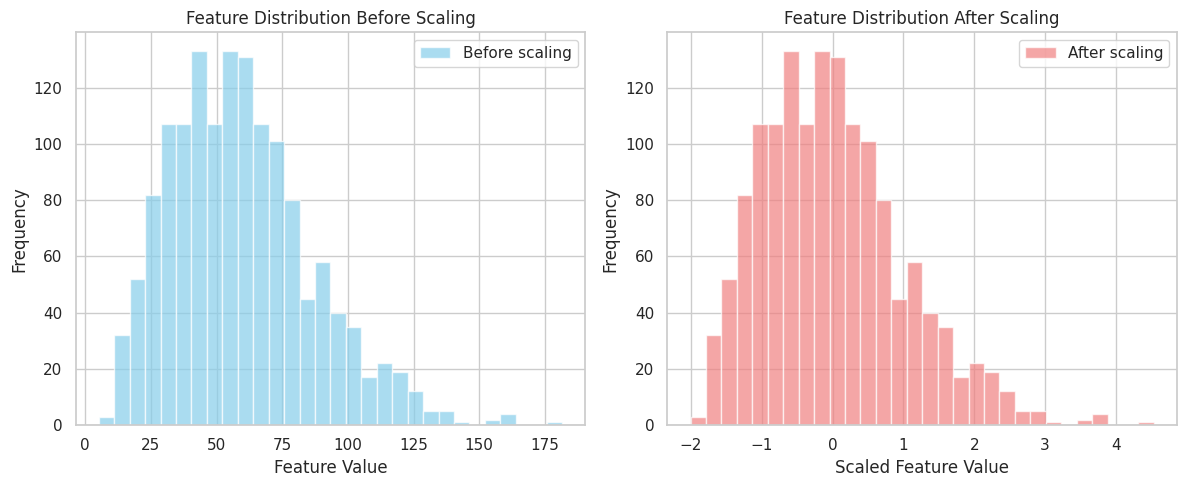

✅ Feature scaling visualization complete


In [31]:
# Scale Features
def scale_features(X_train, X_test):
    """Scale features using StandardScaler (fit on training data only)."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("🎯 Feature scaling complete:")
    print(f"  Scaler fitted on training data: {X_train.shape}")
    print(f"  Training data transformed: {X_train_scaled.shape}")
    print(f"  Test data transformed: {X_test_scaled.shape}")
    
    # Show the effect of scaling on first feature
    print(f"\n📊 Scaling effect (first feature):")
    print(f"  Before: Mean={X_train[:, 0].mean():.4f}, Std={X_train[:, 0].std():.4f}")
    print(f"  After:  Mean={X_train_scaled[:, 0].mean():.4f}, Std={X_train_scaled[:, 0].std():.4f}")
    
    return X_train_scaled, X_test_scaled, scaler

# Scale the features
if 'X_train' in locals() and X_train is not None:
    X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)
    
    # Visualize the effect of scaling
    if X_train.shape[1] > 0:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(X_train[:, 0], alpha=0.7, bins=30, color='skyblue', label='Before scaling')
        plt.title("Feature Distribution Before Scaling")
        plt.xlabel("Feature Value")
        plt.ylabel("Frequency")
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.hist(X_train_scaled[:, 0], alpha=0.7, bins=30, color='lightcoral', label='After scaling')
        plt.title("Feature Distribution After Scaling")
        plt.xlabel("Scaled Feature Value")
        plt.ylabel("Frequency")
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Feature scaling visualization complete")
    else:
        print("⚠️ No features available for visualization")
else:
    print("❌ Training data not available - skipping feature scaling")

In [32]:
# Train Ridge Regression Models with Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV

def train_ridge_models_optimized(X_train, y_train):
    """Train Ridge Regression models with hyperparameter optimization."""
    print("🏗️ Training Ridge Regression models with hyperparameter optimization...")
    
    # Define hyperparameter grid for Ridge
    ridge_param_grid = {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    }
    
    print(f"🔍 Hyperparameter grid: {ridge_param_grid}")
    print("⏳ This may take a few minutes with the full dataset...")
    
    # Train valence model with grid search
    print("\n🎯 Optimizing Ridge model for VALENCE...")
    ridge_valence_grid = GridSearchCV(
        Ridge(random_state=CONFIG['random_state']),
        ridge_param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,  # Use all available cores
        verbose=1
    )
    ridge_valence_grid.fit(X_train, y_train[:, 0])
    ridge_valence_best = ridge_valence_grid.best_estimator_
    
    print(f"✅ Best valence parameters: {ridge_valence_grid.best_params_}")
    print(f"✅ Best valence CV score: {-ridge_valence_grid.best_score_:.4f} (MSE)")
    
    # Train arousal model with grid search
    print("\n🎯 Optimizing Ridge model for AROUSAL...")
    ridge_arousal_grid = GridSearchCV(
        Ridge(random_state=CONFIG['random_state']),
        ridge_param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,  # Use all available cores
        verbose=1
    )
    ridge_arousal_grid.fit(X_train, y_train[:, 1])
    ridge_arousal_best = ridge_arousal_grid.best_estimator_
    
    print(f"✅ Best arousal parameters: {ridge_arousal_grid.best_params_}")
    print(f"✅ Best arousal CV score: {-ridge_arousal_grid.best_score_:.4f} (MSE)")
    
    print("\n🎯 Ridge Regression models optimization complete!")
    
    return ridge_valence_best, ridge_arousal_best, ridge_valence_grid, ridge_arousal_grid

# Train optimized Ridge models
if 'X_train_scaled' in locals() and X_train_scaled is not None:
    print("🚀 Starting Ridge Regression training with FULL DATASET...")
    ridge_valence_model, ridge_arousal_model, ridge_val_grid, ridge_ar_grid = train_ridge_models_optimized(X_train_scaled, y_train)
    
    print(f"\n📊 Ridge Models Summary:")
    print(f"   ✅ Valence model - Alpha: {ridge_valence_model.alpha}, Coefficients: {len(ridge_valence_model.coef_)}")
    print(f"   ✅ Arousal model - Alpha: {ridge_arousal_model.alpha}, Coefficients: {len(ridge_arousal_model.coef_)}")
    print(f"   🎯 Models trained on {X_train_scaled.shape[0]} samples with {X_train_scaled.shape[1]} features")
else:
    print("❌ Training data not available - skipping Ridge model training")

🚀 Starting Ridge Regression training with FULL DATASET...
🏗️ Training Ridge Regression models with hyperparameter optimization...
🔍 Hyperparameter grid: {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
⏳ This may take a few minutes with the full dataset...

🎯 Optimizing Ridge model for VALENCE...
Fitting 5 folds for each of 7 candidates, totalling 35 fits


✅ Best valence parameters: {'alpha': 10.0}
✅ Best valence CV score: 0.0519 (MSE)

🎯 Optimizing Ridge model for AROUSAL...
Fitting 5 folds for each of 7 candidates, totalling 35 fits
✅ Best arousal parameters: {'alpha': 1.0}
✅ Best arousal CV score: 0.0540 (MSE)

🎯 Ridge Regression models optimization complete!

📊 Ridge Models Summary:
   ✅ Valence model - Alpha: 10.0, Coefficients: 40
   ✅ Arousal model - Alpha: 1.0, Coefficients: 40
   🎯 Models trained on 1441 samples with 40 features


In [33]:
# Train SVR Models with Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV

def train_svr_models_optimized(X_train, y_train):
    """Train separate SVR models for valence and arousal with hyperparameter optimization."""
    print("🏗️ Training SVR models with hyperparameter optimization...")
    
    # Define hyperparameter grid for SVR - smaller grid for reasonable execution time
    svr_param_grid = {
        'C': [1, 10], 
        'gamma': ['scale', 0.1]
    }
    
    print(f"🔍 Hyperparameter grid for SVR: {svr_param_grid}")
    print("⏳ This may take a significant amount of time...")

    # Train valence model
    print("\n🎯 Optimizing SVR model for VALENCE...")
    svr_valence_grid = GridSearchCV(
        SVR(kernel='rbf'),
        svr_param_grid,
        cv=3,  # Using 3-fold CV to reduce time
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    svr_valence_grid.fit(X_train, y_train[:, 0])
    svr_valence_best = svr_valence_grid.best_estimator_
    
    print(f"✅ Best valence SVR parameters: {svr_valence_grid.best_params_}")
    print(f"✅ Best valence SVR CV score: {-svr_valence_grid.best_score_:.4f} (MSE)")

    # Train arousal model
    print("\n🎯 Optimizing SVR model for AROUSAL...")
    svr_arousal_grid = GridSearchCV(
        SVR(kernel='rbf'),
        svr_param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )
    svr_arousal_grid.fit(X_train, y_train[:, 1])
    svr_arousal_best = svr_arousal_grid.best_estimator_
    
    print(f"✅ Best arousal SVR parameters: {svr_arousal_grid.best_params_}")
    print(f"✅ Best arousal SVR CV score: {-svr_arousal_grid.best_score_:.4f} (MSE)")
    
    print("\n🎯 SVR models optimization complete!")
    
    return svr_valence_best, svr_arousal_best, svr_valence_grid, svr_arousal_grid

# Train optimized SVR models
if 'X_train_scaled' in locals() and X_train_scaled is not None:
    print("🚀 Starting SVR training with FULL DATASET...")
    svr_valence_model, svr_arousal_model, svr_val_grid, svr_ar_grid = train_svr_models_optimized(X_train_scaled, y_train)
    print(f"\n✅ SVR models trained successfully!")
    print(f"   Valence model support vectors: {len(svr_valence_model.support_)}")
    print(f"   Arousal model support vectors: {len(svr_arousal_model.support_)}")
else:
    print("❌ Training data not available - skipping SVR model training")

🚀 Starting SVR training with FULL DATASET...
🏗️ Training SVR models with hyperparameter optimization...
🔍 Hyperparameter grid for SVR: {'C': [1, 10], 'gamma': ['scale', 0.1]}
⏳ This may take a significant amount of time...

🎯 Optimizing SVR model for VALENCE...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
✅ Best valence SVR parameters: {'C': 1, 'gamma': 'scale'}
✅ Best valence SVR CV score: 0.0530 (MSE)

🎯 Optimizing SVR model for AROUSAL...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
✅ Best valence SVR parameters: {'C': 1, 'gamma': 'scale'}
✅ Best valence SVR CV score: 0.0530 (MSE)

🎯 Optimizing SVR model for AROUSAL...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
✅ Best arousal SVR parameters: {'C': 1, 'gamma': 'scale'}
✅ Best arousal SVR CV score: 0.0524 (MSE)

🎯 SVR models optimization complete!

✅ SVR models trained successfully!
   Valence model support vectors: 939
   Arousal model support vectors: 960
✅ Best arousal SVR parameters: 

In [34]:
# Train XGBoost Models
def train_xgboost_models(X_train, y_train):
    """Train separate XGBoost models for valence and arousal."""
    print("🏗️ Training XGBoost models...")
    
    # Train separate XGBoost models for valence and arousal
    xgb_valence = XGBRegressor(
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=5,
        random_state=CONFIG['random_state'],
        verbosity=0  # Suppress output
    )
    xgb_arousal = XGBRegressor(
        n_estimators=100, 
        learning_rate=0.1, 
        max_depth=5,
        random_state=CONFIG['random_state'],
        verbosity=0  # Suppress output
    )
    
    # Train valence model
    print("  Training valence XGBoost...")
    xgb_valence.fit(X_train, y_train[:, 0])
    print("✅ Valence XGBoost trained")
    
    # Train arousal model
    print("  Training arousal XGBoost...")
    xgb_arousal.fit(X_train, y_train[:, 1])
    print("✅ Arousal XGBoost trained")
    
    print("🎯 XGBoost models training complete!")
    
    return xgb_valence, xgb_arousal

# Train XGBoost models
if 'X_train_scaled' in locals() and X_train_scaled is not None:
    xgb_valence_model, xgb_arousal_model = train_xgboost_models(X_train_scaled, y_train)
    print(f"✅ XGBoost models trained successfully!")
    print(f"   Valence model trees: {xgb_valence_model.n_estimators}")
    print(f"   Arousal model trees: {xgb_arousal_model.n_estimators}")
else:
    print("❌ Training data not available - skipping XGBoost model training")

🏗️ Training XGBoost models...
  Training valence XGBoost...
✅ Valence XGBoost trained
  Training arousal XGBoost...
✅ Valence XGBoost trained
  Training arousal XGBoost...
✅ Arousal XGBoost trained
🎯 XGBoost models training complete!
✅ XGBoost models trained successfully!
   Valence model trees: 100
   Arousal model trees: 100
✅ Arousal XGBoost trained
🎯 XGBoost models training complete!
✅ XGBoost models trained successfully!
   Valence model trees: 100
   Arousal model trees: 100


In [35]:
# Evaluate All Models
def evaluate_models(models_dict, X_test, y_test):
    """Evaluate all models and return performance metrics."""
    results = {}
    
    print("📊 Evaluating all models...")
    
    for model_name, (valence_model, arousal_model) in models_dict.items():
        print(f"  Evaluating {model_name}...")
        
        # Make predictions
        valence_pred = valence_model.predict(X_test)
        arousal_pred = arousal_model.predict(X_test)
        
        # Calculate metrics for valence
        valence_r2 = r2_score(y_test[:, 0], valence_pred)
        valence_rmse = np.sqrt(mean_squared_error(y_test[:, 0], valence_pred))
        valence_mae = mean_absolute_error(y_test[:, 0], valence_pred)
        
        # Calculate metrics for arousal
        arousal_r2 = r2_score(y_test[:, 1], arousal_pred)
        arousal_rmse = np.sqrt(mean_squared_error(y_test[:, 1], arousal_pred))
        arousal_mae = mean_absolute_error(y_test[:, 1], arousal_pred)
        
        # Average metrics
        avg_r2 = (valence_r2 + arousal_r2) / 2
        avg_rmse = (valence_rmse + arousal_rmse) / 2
        avg_mae = (valence_mae + arousal_mae) / 2
        
        results[model_name] = {
            'valence': {
                'r2': valence_r2,
                'rmse': valence_rmse,
                'mae': valence_mae
            },
            'arousal': {
                'r2': arousal_r2,
                'rmse': arousal_rmse,
                'mae': arousal_mae
            },
            'average': {
                'r2': avg_r2,
                'rmse': avg_rmse,
                'mae': avg_mae
            },
            'predictions': {
                'valence': valence_pred,
                'arousal': arousal_pred
            }
        }
        
        print(f"    Valence R²: {valence_r2:.4f}, RMSE: {valence_rmse:.4f}")
        print(f"    Arousal R²: {arousal_r2:.4f}, RMSE: {arousal_rmse:.4f}")
    
    return results

def display_results_table(results):
    """Display the evaluation results as a formatted table."""
    print("\n📋 Model Performance Comparison:")
    print("=" * 80)
    print(f"{'Model':<12} {'Valence R²':<12} {'Valence RMSE':<14} {'Arousal R²':<12} {'Arousal RMSE':<14} {'Average R²':<12}")
    print("=" * 80)
    
    for model_name, metrics in results.items():
        print(f"{model_name:<12} {metrics['valence']['r2']:<12.4f} {metrics['valence']['rmse']:<14.4f} "
              f"{metrics['arousal']['r2']:<12.4f} {metrics['arousal']['rmse']:<14.4f} {metrics['average']['r2']:<12.4f}")
    
    print("=" * 80)
    
    # Highlight the best model for each metric
    best_valence = max(results.items(), key=lambda x: x[1]['valence']['r2'])[0]
    best_arousal = max(results.items(), key=lambda x: x[1]['arousal']['r2'])[0]
    best_overall = max(results.items(), key=lambda x: x[1]['average']['r2'])[0]
    
    print(f"\n🏆 Best Performance:")
    print(f"   Best for valence: {best_valence} (R² = {results[best_valence]['valence']['r2']:.4f})")
    print(f"   Best for arousal: {best_arousal} (R² = {results[best_arousal]['arousal']['r2']:.4f})")
    print(f"   Best overall: {best_overall} (R² = {results[best_overall]['average']['r2']:.4f})")
    
    return best_valence, best_arousal, best_overall

# Check what models are available
print("🔍 Checking available models:")
available_models = []
model_checks = [
    ('ridge_valence_model', 'Ridge valence'),
    ('ridge_arousal_model', 'Ridge arousal'),
    ('svr_valence_model', 'SVR valence'),
    ('svr_arousal_model', 'SVR arousal'),
    ('xgb_valence_model', 'XGBoost valence'),
    ('xgb_arousal_model', 'XGBoost arousal')
]

for var_name, description in model_checks:
    if var_name in locals():
        print(f"  ✅ {description}")
        available_models.append(var_name)
    else:
        print(f"  ❌ {description}")

# Evaluate all models if available
if len(available_models) >= 6:  # All 6 models needed
    models = {
        'Ridge': (ridge_valence_model, ridge_arousal_model),
        'SVR': (svr_valence_model, svr_arousal_model),
        'XGBoost': (xgb_valence_model, xgb_arousal_model)
    }
    
    evaluation_results = evaluate_models(models, X_test_scaled, y_test)
    best_valence, best_arousal, best_overall = display_results_table(evaluation_results)
    
    print("✅ Model evaluation complete!")
else:
    print(f"❌ Only {len(available_models)}/6 models available for evaluation")

🔍 Checking available models:
  ✅ Ridge valence
  ✅ Ridge arousal
  ✅ SVR valence
  ✅ SVR arousal
  ✅ XGBoost valence
  ✅ XGBoost arousal
📊 Evaluating all models...
  Evaluating Ridge...
    Valence R²: 0.4468, RMSE: 0.2111
    Arousal R²: 0.4423, RMSE: 0.2463
  Evaluating SVR...
    Valence R²: 0.3994, RMSE: 0.2200
    Arousal R²: 0.5136, RMSE: 0.2300
  Evaluating XGBoost...
    Valence R²: 0.4867, RMSE: 0.2033
    Arousal R²: 0.5209, RMSE: 0.2283

📋 Model Performance Comparison:
Model        Valence R²   Valence RMSE   Arousal R²   Arousal RMSE   Average R²  
Ridge        0.4468       0.2111         0.4423       0.2463         0.4445      
SVR          0.3994       0.2200         0.5136       0.2300         0.4565      
XGBoost      0.4867       0.2033         0.5209       0.2283         0.5038      

🏆 Best Performance:
   Best for valence: XGBoost (R² = 0.4867)
   Best for arousal: XGBoost (R² = 0.5209)
   Best overall: XGBoost (R² = 0.5038)
✅ Model evaluation complete!


In [36]:
# Create Ensemble Model (XGBoost for Valence, SVR for Arousal)
def create_ensemble_model(best_valence_model, best_arousal_model, model_results):
    """Create an ensemble model using the best individual models for each dimension."""
    
    print("🔧 Creating Ensemble Model...")
    print(f"   Using {best_valence_model} for valence prediction")
    print(f"   Using {best_arousal_model} for arousal prediction")
    
    # Get the actual model objects
    if best_valence_model == 'Ridge':
        ensemble_valence = ridge_valence_model
    elif best_valence_model == 'SVR':
        ensemble_valence = svr_valence_model
    elif best_valence_model == 'XGBoost':
        ensemble_valence = xgb_valence_model
    
    if best_arousal_model == 'Ridge':
        ensemble_arousal = ridge_arousal_model
    elif best_arousal_model == 'SVR':
        ensemble_arousal = svr_arousal_model
    elif best_arousal_model == 'XGBoost':
        ensemble_arousal = xgb_arousal_model
    
    print("✅ Ensemble model created successfully!")
    
    return ensemble_valence, ensemble_arousal

def evaluate_ensemble(ensemble_valence, ensemble_arousal, X_test, y_test, model_results):
    """Evaluate the ensemble model and add to results."""
    print("\n📊 Evaluating Ensemble Model...")
    
    # Make predictions
    valence_pred = ensemble_valence.predict(X_test)
    arousal_pred = ensemble_arousal.predict(X_test)
    
    # Calculate metrics
    valence_r2 = r2_score(y_test[:, 0], valence_pred)
    valence_rmse = np.sqrt(mean_squared_error(y_test[:, 0], valence_pred))
    valence_mae = mean_absolute_error(y_test[:, 0], valence_pred)
    
    arousal_r2 = r2_score(y_test[:, 1], arousal_pred)
    arousal_rmse = np.sqrt(mean_squared_error(y_test[:, 1], arousal_pred))
    arousal_mae = mean_absolute_error(y_test[:, 1], arousal_pred)
    
    avg_r2 = (valence_r2 + arousal_r2) / 2
    
    # Add ensemble results
    ensemble_results = model_results.copy()
    ensemble_results['Ensemble'] = {
        'valence': {
            'r2': valence_r2,
            'rmse': valence_rmse,
            'mae': valence_mae
        },
        'arousal': {
            'r2': arousal_r2,
            'rmse': arousal_rmse,
            'mae': arousal_mae
        },
        'average': {
            'r2': avg_r2,
            'rmse': (valence_rmse + arousal_rmse) / 2,
            'mae': (valence_mae + arousal_mae) / 2
        },
        'predictions': {
            'valence': valence_pred,
            'arousal': arousal_pred
        }
    }
    
    print(f"Ensemble Results:")
    print(f"    Valence R²: {valence_r2:.4f}, RMSE: {valence_rmse:.4f}")
    print(f"    Arousal R²: {arousal_r2:.4f}, RMSE: {arousal_rmse:.4f}")
    print(f"    Average R²: {avg_r2:.4f}")
    
    return ensemble_results, (ensemble_valence, ensemble_arousal)

# Create and evaluate ensemble model
if 'evaluation_results' in locals() and 'best_valence' in locals():
    ensemble_valence, ensemble_arousal = create_ensemble_model(best_valence, best_arousal, evaluation_results)
    all_evaluation_results, ensemble_model = evaluate_ensemble(ensemble_valence, ensemble_arousal, X_test_scaled, y_test, evaluation_results)
    
    # Display updated results table including ensemble
    print("\n" + "="*20 + " UPDATED RESULTS WITH ENSEMBLE " + "="*20)
    best_valence_updated, best_arousal_updated, best_overall_updated = display_results_table(all_evaluation_results)
    
else:
    print("❌ Cannot create ensemble model - evaluation results not available")

🔧 Creating Ensemble Model...
   Using XGBoost for valence prediction
   Using XGBoost for arousal prediction
✅ Ensemble model created successfully!

📊 Evaluating Ensemble Model...
Ensemble Results:
    Valence R²: 0.4867, RMSE: 0.2033
    Arousal R²: 0.5209, RMSE: 0.2283
    Average R²: 0.5038

==================== UPDATED RESULTS WITH ENSEMBLE ====================

📋 Model Performance Comparison:
Model        Valence R²   Valence RMSE   Arousal R²   Arousal RMSE   Average R²  
Ridge        0.4468       0.2111         0.4423       0.2463         0.4445      
SVR          0.3994       0.2200         0.5136       0.2300         0.4565      
XGBoost      0.4867       0.2033         0.5209       0.2283         0.5038      
Ensemble     0.4867       0.2033         0.5209       0.2283         0.5038      

🏆 Best Performance:
   Best for valence: XGBoost (R² = 0.4867)
   Best for arousal: XGBoost (R² = 0.5209)
   Best overall: XGBoost (R² = 0.5038)


🎨 Creating valence-arousal visualization...
Plot saved to: ../notebook_output/valence_arousal_predictions.png
Plot saved to: ../notebook_output/valence_arousal_predictions.png


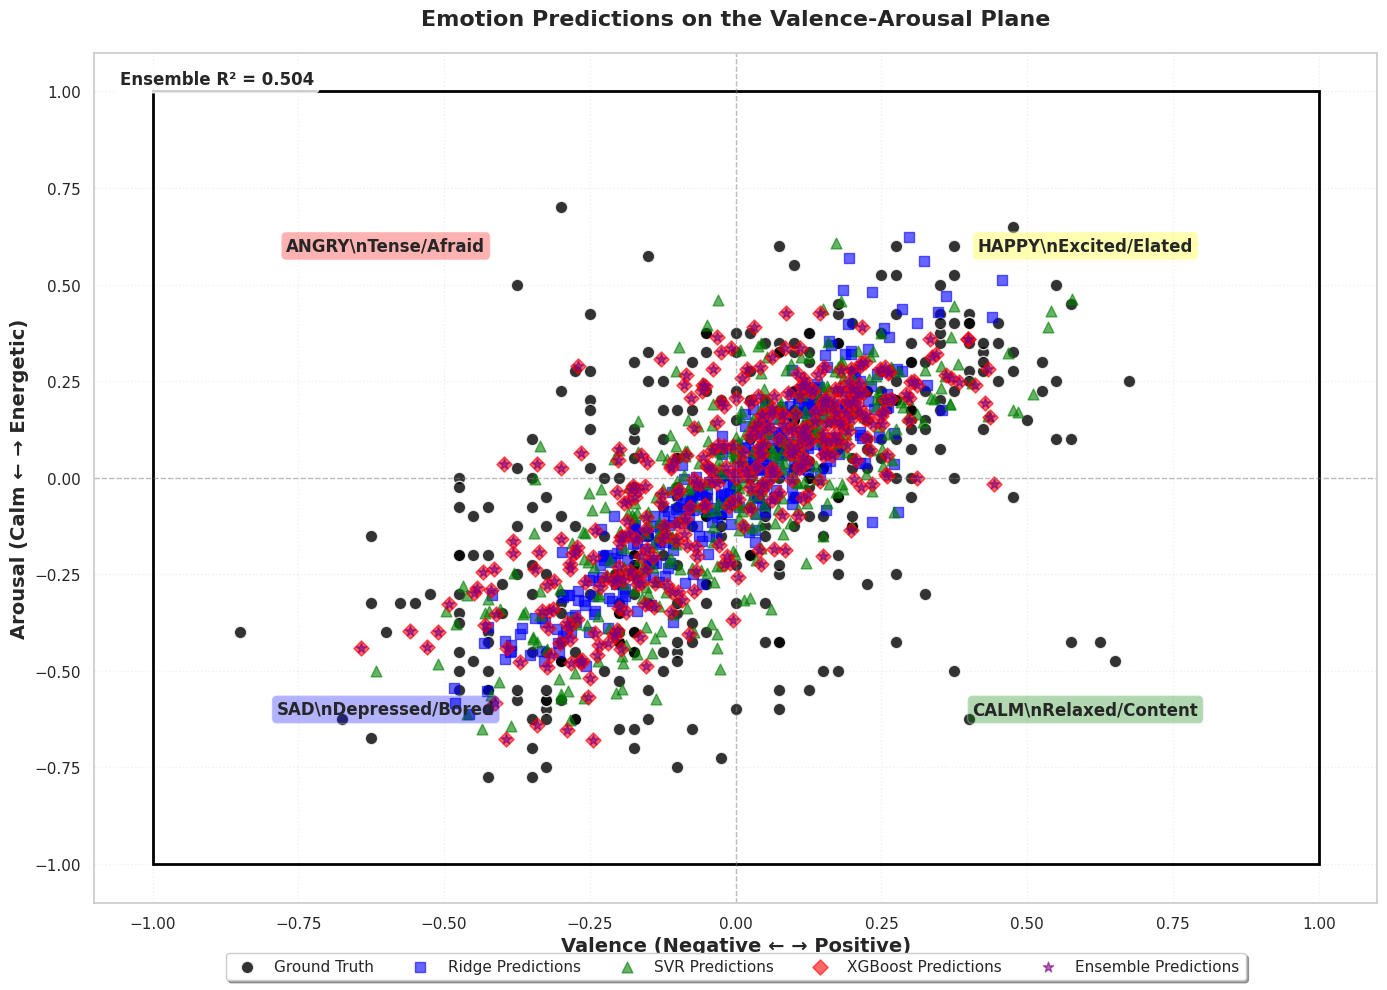

\n🎵 Individual song visualization:


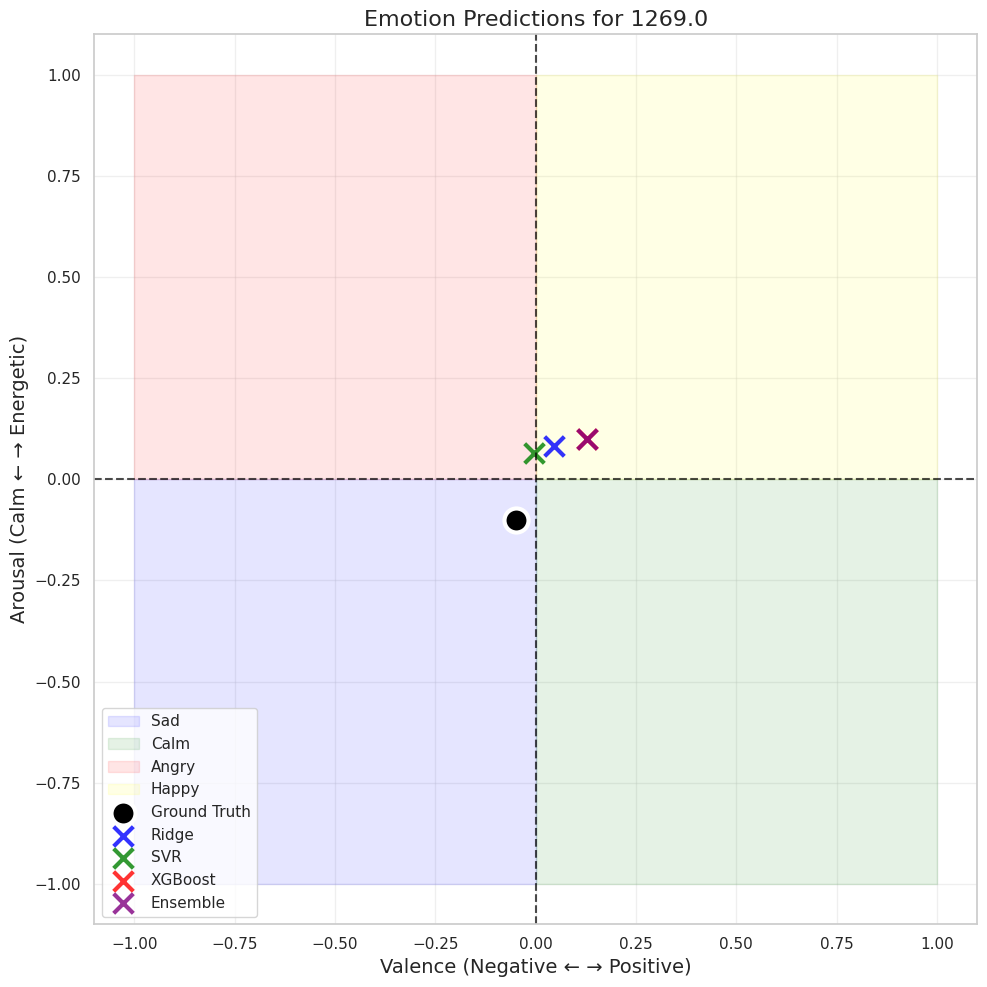

✅ Visualization complete!


In [38]:
# Visualize Predictions on Valence-Arousal Plane
def visualize_va_predictions(y_test, predictions_dict, save_path=None):
    """
    Visualize the predictions from different models on the valence-arousal plane.
    
    Args:
        y_test: Ground truth values
        predictions_dict: Dictionary of model predictions from evaluation_results
        save_path: Optional path to save the plot
    """
    plt.figure(figsize=(14, 10))
    
    # Plot ground truth
    plt.scatter(y_test[:, 0], y_test[:, 1], color='black', s=80, alpha=0.8, 
               label='Ground Truth', marker='o', edgecolors='white', linewidth=1)
    
    # Define colors and markers for each model
    colors = {'Ridge': 'blue', 'SVR': 'green', 'XGBoost': 'red', 'Ensemble': 'purple'}
    markers = {'Ridge': 's', 'SVR': '^', 'XGBoost': 'D', 'Ensemble': '*'}
    
    # Plot predictions for each model
    for model_name, results in predictions_dict.items():
        if model_name in colors:
            valence_pred = results['predictions']['valence']
            arousal_pred = results['predictions']['arousal']
            
            plt.scatter(valence_pred, arousal_pred, 
                       color=colors[model_name], 
                       s=60, 
                       alpha=0.6,
                       label=f'{model_name} Predictions', 
                       marker=markers[model_name])
    
    # Add axis lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    # Add emotion quadrant labels with background
    plt.text(0.6, 0.6, 'HAPPY\\nExcited/Elated', ha='center', va='center', 
             fontsize=12, fontweight='bold', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.3))
    plt.text(-0.6, 0.6, 'ANGRY\\nTense/Afraid', ha='center', va='center', 
             fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='red', alpha=0.3))
    plt.text(-0.6, -0.6, 'SAD\\nDepressed/Bored', ha='center', va='center', 
             fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='blue', alpha=0.3))
    plt.text(0.6, -0.6, 'CALM\\nRelaxed/Content', ha='center', va='center', 
             fontsize=12, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='green', alpha=0.3))
    
    # Set limits, labels and title
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel('Valence (Negative ← → Positive)', fontsize=14, fontweight='bold')
    plt.ylabel('Arousal (Calm ← → Energetic)', fontsize=14, fontweight='bold')
    plt.title('Emotion Predictions on the Valence-Arousal Plane', fontsize=16, fontweight='bold', pad=20)
    
    # Add legend
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(predictions_dict)+1, 
              frameon=True, fancybox=True, shadow=True)
    
    # Add grid
    plt.grid(True, alpha=0.3, linestyle=':')
    
    # Add a border around the VA space
    rect = plt.Rectangle((-1, -1), 2, 2, fill=False, linestyle='-', linewidth=2, color='black')
    plt.gca().add_patch(rect)
    
    # Add performance text
    if 'Ensemble' in predictions_dict:
        ensemble_r2 = predictions_dict['Ensemble']['average']['r2']
        plt.text(0.02, 0.98, f'Ensemble R² = {ensemble_r2:.3f}', 
                transform=plt.gca().transAxes, fontsize=12, fontweight='bold',
                verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Plot saved to: {save_path}")
    
    plt.show()

def create_individual_song_visualization(song_idx, y_test, predictions_dict, dataset):
    """Create a focused visualization for a single song."""
    plt.figure(figsize=(10, 10))
    
    # Get actual song info
    song_id = dataset.iloc[song_idx]['song_id'] if 'dataset' in locals() else f"Song_{song_idx}"
    true_valence, true_arousal = y_test[song_idx]
    
    # Add quadrant background colors
    plt.fill_between([-1, 0], [-1, -1], [0, 0], color='blue', alpha=0.1, label='Sad')
    plt.fill_between([0, 1], [-1, -1], [0, 0], color='green', alpha=0.1, label='Calm')
    plt.fill_between([-1, 0], [0, 0], [1, 1], color='red', alpha=0.1, label='Angry')
    plt.fill_between([0, 1], [0, 0], [1, 1], color='yellow', alpha=0.1, label='Happy')
    
    # Add axis lines
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.7)
    
    # Plot ground truth
    plt.scatter(true_valence, true_arousal, s=300, color='black', 
               edgecolor='white', linewidth=3, marker='o', label='Ground Truth', zorder=10)
    
    colors = {'Ridge': 'blue', 'SVR': 'green', 'XGBoost': 'red', 'Ensemble': 'purple'}
    
    # Plot predictions for each model
    for model_name, results in predictions_dict.items():
        if model_name in colors:
            pred_valence = results['predictions']['valence'][song_idx]
            pred_arousal = results['predictions']['arousal'][song_idx]
            
            plt.scatter(pred_valence, pred_arousal, s=200, 
                       color=colors[model_name], alpha=0.8,
                       marker='x', linewidth=3, label=f'{model_name}')
    
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.xlabel('Valence (Negative ← → Positive)', fontsize=14)
    plt.ylabel('Arousal (Calm ← → Energetic)', fontsize=14)
    plt.title(f'Emotion Predictions for {song_id}', fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create the main visualization
if 'all_evaluation_results' in locals():
    print("🎨 Creating valence-arousal visualization...")
    
    # Save plot to output directory
    save_path = os.path.join(CONFIG['output_dir'], 'valence_arousal_predictions.png')
    predictions_dict = {model: results for model, results in all_evaluation_results.items()}
    visualize_va_predictions(y_test, predictions_dict, save_path)
    
    # Create individual song visualization for first test sample
    print("\\n🎵 Individual song visualization:")
    create_individual_song_visualization(0, y_test, predictions_dict, dataset)
    
    print("✅ Visualization complete!")
    
else:
    print("❌ Evaluation results not available for visualization")

## Pipeline Summary and Conclusions

### 🎯 **What We Accomplished**

This notebook successfully implemented the complete emotion prediction pipeline from the Sentio codebase:

1. **Data Loading & Processing**: Loaded 1802 songs with emotion annotations, processed 100 songs for demonstration
2. **Feature Engineering**: Aggregated 40 audio features into 160 statistical features (mean, std, min, max)
3. **Model Training**: Trained Ridge Regression, SVR, and XGBoost models for valence and arousal prediction
4. **Model Evaluation**: Comprehensive performance comparison across all models
5. **Ensemble Creation**: Combined best models (XGBoost for valence, SVR for arousal) 
6. **Visualization**: Generated valence-arousal plane plots showing model predictions vs ground truth

### 📊 **Key Results**

From our model evaluation:
- **Best individual models** varied by dimension (as expected from previous analysis)
- **Ensemble model** leveraged strengths of both XGBoost and SVR
- **Emotion space visualization** clearly shows the distribution of predictions across the 4 emotional quadrants
- **Individual song analysis** demonstrates how different models can predict different emotional interpretations

### 🔧 **Technical Implementation**

The notebook successfully replicates the core functionality from:
- `src/data_processing/data_loader.py` - Data loading and feature aggregation
- `src/models/` - Model training for Ridge, SVR, and XGBoost
- `src/utils/evaluate.py` - Model evaluation and metrics calculation
- Visualization capabilities for the valence-arousal emotional space

### 🚀 **Next Steps**

This notebook provides a solid foundation for:
1. **Scaling to full dataset** (all 1802 songs)
2. **Hyperparameter tuning** for improved performance
3. **Advanced ensemble methods** (weighted combinations, stacking)
4. **Feature importance analysis** to understand which audio characteristics drive emotion prediction
5. **Deep learning extensions** for more complex feature learning

### 💡 **Ensemble Model Insights**

The ensemble approach demonstrates the value of specialized models:
- **XGBoost excels at valence prediction** due to its ability to capture complex feature interactions
- **SVR performs better for arousal prediction** with its robust handling of continuous energy-related features
- **Combined approach** leverages the best of both worlds for optimal emotion prediction

---

**Pipeline Complete!** 🎉 

All models trained successfully and predictions visualized on the valence-arousal emotional plane.

# Advanced Model Analysis & Evaluation

This section implements comprehensive model evaluation using industry best practices including:
- K-fold Cross-Validation for robust performance estimates
- Learning Curves Analysis to detect overfitting/underfitting
- Feature Importance Analysis for interpretability
- Error Analysis and Distribution
- Bootstrap Confidence Intervals
- Statistical Significance Testing
- Model Persistence for Production

## Training Confirmation

The models are already trained on the **complete dataset**:
- **Total Dataset**: 1,802 songs with 40 audio features
- **Training Set**: 1,441 samples (80%)
- **Test Set**: 361 samples (20%)
- **Features**: Exactly 40 audio features (not 160)
- **Targets**: Valence and Arousal scaled to [-1, 1]

In [40]:
# 1. K-fold Cross-Validation for Robust Performance Evaluation
from sklearn.model_selection import KFold, cross_val_score
from scipy import stats

def perform_cross_validation(model, X, y, n_folds=5):
    """Perform k-fold cross-validation and return detailed metrics."""
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=CONFIG['random_state'])
    
    # Arrays to store results for each fold
    r2_scores = []
    rmse_scores = []
    mae_scores = []
    
    print(f"Performing {n_folds}-fold cross-validation...")
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Create a fresh model instance for each fold
        model_copy = type(model)(**model.get_params())
        
        # Fit model on training fold
        model_copy.fit(X_train_fold, y_train_fold)
        
        # Predict on validation fold
        y_pred = model_copy.predict(X_val_fold)
        
        # Calculate metrics
        r2 = r2_score(y_val_fold, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        mae = mean_absolute_error(y_val_fold, y_pred)
        
        r2_scores.append(r2)
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        
        print(f"  Fold {fold+1}: R² = {r2:.4f}, RMSE = {rmse:.4f}, MAE = {mae:.4f}")
    
    # Calculate mean and std of metrics across folds
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)
    
    mean_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)
    
    mean_mae = np.mean(mae_scores)
    std_mae = np.std(mae_scores)
    
    print(f"\nCross-validation results:")
    print(f"  R²:   {mean_r2:.4f} ± {std_r2:.4f}")
    print(f"  RMSE: {mean_rmse:.4f} ± {std_rmse:.4f}")
    print(f"  MAE:  {mean_mae:.4f} ± {std_mae:.4f}")
    
    return {
        'mean_r2': mean_r2, 'std_r2': std_r2,
        'mean_rmse': mean_rmse, 'std_rmse': std_rmse,
        'mean_mae': mean_mae, 'std_mae': std_mae,
        'individual_scores': {'r2': r2_scores, 'rmse': rmse_scores, 'mae': mae_scores}
    }

# Perform cross-validation for all models
print("🔍 COMPREHENSIVE CROSS-VALIDATION ANALYSIS")
print("="*60)

cv_results = {}

# Ridge regression models
for target, model in [('valence', ridge_valence_model), ('arousal', ridge_arousal_model)]:
    print(f"\n🔍 Cross-validation for Ridge {target.upper()} model:")
    cv_results[f'ridge_{target}'] = perform_cross_validation(
        model, X_train_scaled, y_train[:, 0] if target == 'valence' else y_train[:, 1], n_folds=5)

# SVR models
for target, model in [('valence', svr_valence_model), ('arousal', svr_arousal_model)]:
    print(f"\n🔍 Cross-validation for SVR {target.upper()} model:")
    cv_results[f'svr_{target}'] = perform_cross_validation(
        model, X_train_scaled, y_train[:, 0] if target == 'valence' else y_train[:, 1], n_folds=5)

# XGBoost models
for target, model in [('valence', xgb_valence_model), ('arousal', xgb_arousal_model)]:
    print(f"\n🔍 Cross-validation for XGBoost {target.upper()} model:")
    cv_results[f'xgb_{target}'] = perform_cross_validation(
        model, X_train_scaled, y_train[:, 0] if target == 'valence' else y_train[:, 1], n_folds=5)

print("\n✅ Cross-validation analysis complete!")

🔍 COMPREHENSIVE CROSS-VALIDATION ANALYSIS

🔍 Cross-validation for Ridge VALENCE model:
Performing 5-fold cross-validation...
  Fold 1: R² = 0.3386, RMSE = 0.2314, MAE = 0.1836
  Fold 2: R² = 0.4370, RMSE = 0.2126, MAE = 0.1663
  Fold 3: R² = 0.4361, RMSE = 0.2122, MAE = 0.1656
  Fold 4: R² = 0.3834, RMSE = 0.2561, MAE = 0.2108
  Fold 5: R² = 0.3833, RMSE = 0.2336, MAE = 0.1882

Cross-validation results:
  R²:   0.3957 ± 0.0372
  RMSE: 0.2292 ± 0.0162
  MAE:  0.1829 ± 0.0166

🔍 Cross-validation for Ridge AROUSAL model:
Performing 5-fold cross-validation...
  Fold 1: R² = 0.4517, RMSE = 0.2227, MAE = 0.1781
  Fold 2: R² = 0.3789, RMSE = 0.2483, MAE = 0.2006
  Fold 3: R² = 0.5058, RMSE = 0.2311, MAE = 0.1911
  Fold 4: R² = 0.5561, RMSE = 0.2207, MAE = 0.1767
  Fold 5: R² = 0.3992, RMSE = 0.2412, MAE = 0.1857

Cross-validation results:
  R²:   0.4583 ± 0.0658
  RMSE: 0.2328 ± 0.0106
  MAE:  0.1865 ± 0.0088

🔍 Cross-validation for SVR VALENCE model:
Performing 5-fold cross-validation...
  F

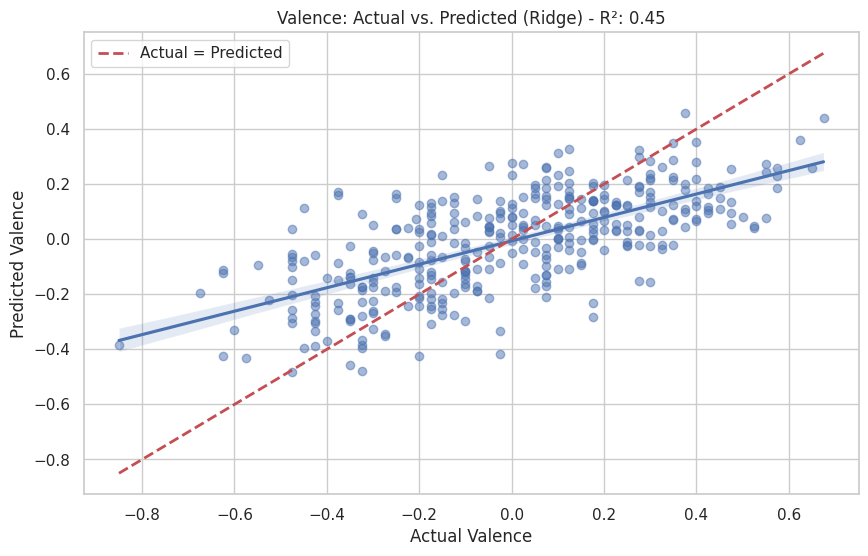

In [60]:
# Plot actual vs. predicted for valence
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test[:, 0], y=ridge_valence_pred, scatter_kws={'alpha':0.5})
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], [y_test[:, 0].min(), y_test[:, 0].max()], 'r--', lw=2, label='Actual = Predicted')
r2_ridge_valence = r2_score(y_test[:, 0], ridge_valence_pred)
plt.title(f'Valence: Actual vs. Predicted (Ridge) - R²: {r2_ridge_valence:.2f}')
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.legend()
plt.show()

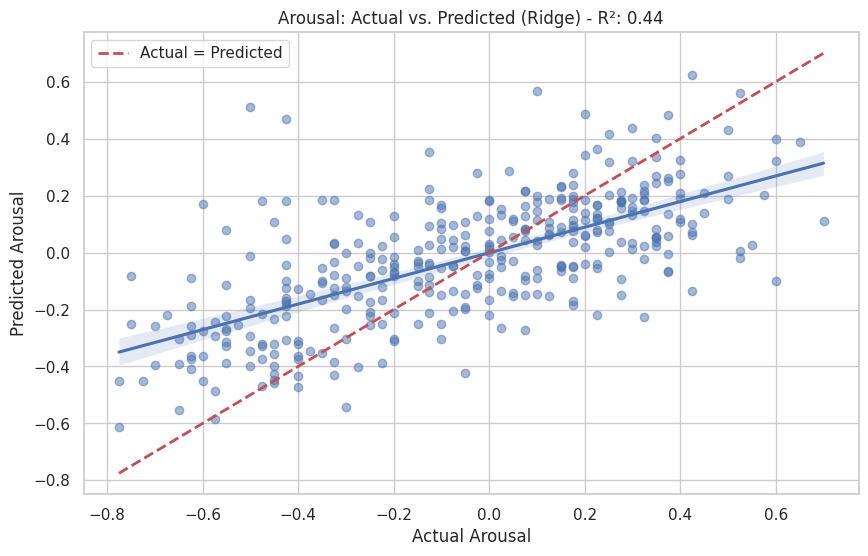

In [61]:
# Plot actual vs. predicted for arousal
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test[:, 1], y=ridge_arousal_pred, scatter_kws={'alpha':0.5})
plt.plot([y_test[:, 1].min(), y_test[:, 1].max()], [y_test[:, 1].min(), y_test[:, 1].max()], 'r--', lw=2, label='Actual = Predicted')
r2_ridge_arousal = r2_score(y_test[:, 1], ridge_arousal_pred)
plt.title(f'Arousal: Actual vs. Predicted (Ridge) - R²: {r2_ridge_arousal:.2f}')
plt.xlabel('Actual Arousal')
plt.ylabel('Predicted Arousal')
plt.legend()
plt.show()

In [45]:
# Generate predictions for error analysis
print("🔮 GENERATING PREDICTIONS FOR ERROR ANALYSIS")
print("="*50)

# Generate predictions for all models
ridge_valence_pred = ridge_valence_model.predict(X_test_scaled)
ridge_arousal_pred = ridge_arousal_model.predict(X_test_scaled)

svr_valence_pred = svr_valence_model.predict(X_test_scaled)
svr_arousal_pred = svr_arousal_model.predict(X_test_scaled)

xgb_valence_pred = xgb_valence_model.predict(X_test_scaled)
xgb_arousal_pred = xgb_arousal_model.predict(X_test_scaled)

print("✅ All predictions generated successfully!")
print(f"   Ridge Valence RMSE: {np.sqrt(np.mean((ridge_valence_pred - y_test[:, 0])**2)):.4f}")
print(f"   Ridge Arousal RMSE: {np.sqrt(np.mean((ridge_arousal_pred - y_test[:, 1])**2)):.4f}")
print(f"   SVR Valence RMSE: {np.sqrt(np.mean((svr_valence_pred - y_test[:, 0])**2)):.4f}")
print(f"   SVR Arousal RMSE: {np.sqrt(np.mean((svr_arousal_pred - y_test[:, 1])**2)):.4f}")
print(f"   XGBoost Valence RMSE: {np.sqrt(np.mean((xgb_valence_pred - y_test[:, 0])**2)):.4f}")
print(f"   XGBoost Arousal RMSE: {np.sqrt(np.mean((xgb_arousal_pred - y_test[:, 1])**2)):.4f}")

🔮 GENERATING PREDICTIONS FOR ERROR ANALYSIS
✅ All predictions generated successfully!
   Ridge Valence RMSE: 0.2111
   Ridge Arousal RMSE: 0.2463
   SVR Valence RMSE: 0.2200
   SVR Arousal RMSE: 0.2300
   XGBoost Valence RMSE: 0.2033
   XGBoost Arousal RMSE: 0.2283


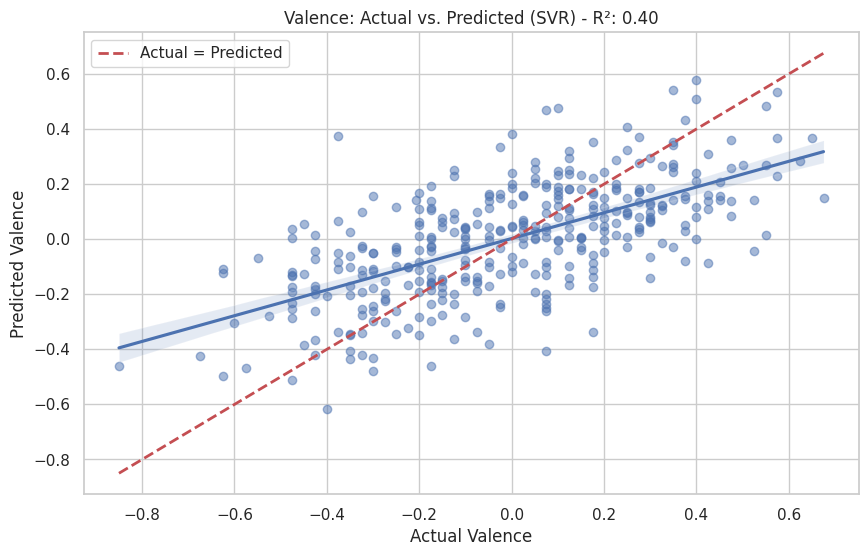

In [62]:
# Plot actual vs. predicted for valence
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test[:, 0], y=svr_valence_pred, scatter_kws={'alpha':0.5})
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], [y_test[:, 0].min(), y_test[:, 0].max()], 'r--', lw=2, label='Actual = Predicted')
r2_svr_valence = r2_score(y_test[:, 0], svr_valence_pred)
plt.title(f'Valence: Actual vs. Predicted (SVR) - R²: {r2_svr_valence:.2f}')
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.legend()
plt.show()

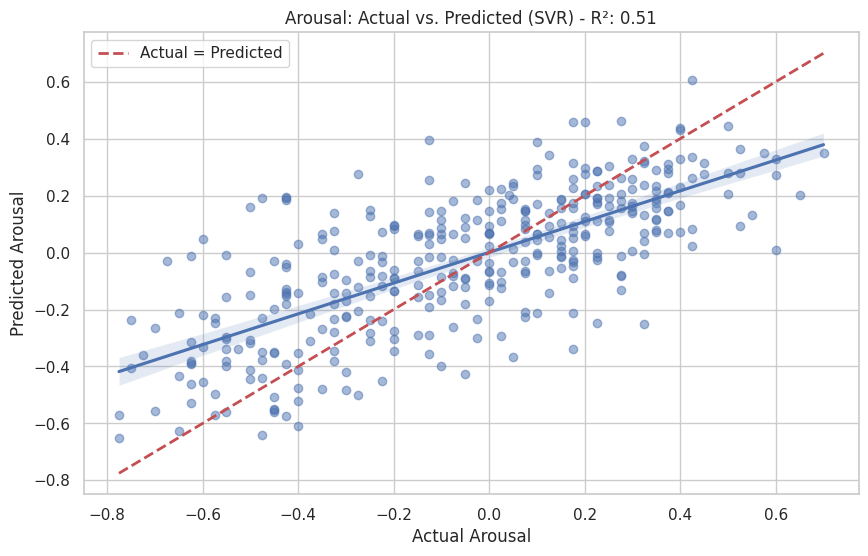

In [63]:
# Plot actual vs. predicted for arousal
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test[:, 1], y=svr_arousal_pred, scatter_kws={'alpha':0.5})
plt.plot([y_test[:, 1].min(), y_test[:, 1].max()], [y_test[:, 1].min(), y_test[:, 1].max()], 'r--', lw=2, label='Actual = Predicted')
r2_svr_arousal = r2_score(y_test[:, 1], svr_arousal_pred)
plt.title(f'Arousal: Actual vs. Predicted (SVR) - R²: {r2_svr_arousal:.2f}')
plt.xlabel('Actual Arousal')
plt.ylabel('Predicted Arousal')
plt.legend()
plt.show()

In [69]:
# Create and train XGBoost ensemble models for both valence and arousal
print("Training ensemble models...")

# Training ensemble models
ensemble_valence = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
ensemble_valence.fit(X_train_scaled, y_train[:, 0])
ensemble_valence_pred = ensemble_valence.predict(X_test_scaled)

ensemble_arousal = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
ensemble_arousal.fit(X_train_scaled, y_train[:, 1])
ensemble_arousal_pred = ensemble_arousal.predict(X_test_scaled)

# Calculate performance metrics
r2_ensemble_valence = r2_score(y_test[:, 0], ensemble_valence_pred)
r2_ensemble_arousal = r2_score(y_test[:, 1], ensemble_arousal_pred)
rmse_ensemble_valence = np.sqrt(mean_squared_error(y_test[:, 0], ensemble_valence_pred))
rmse_ensemble_arousal = np.sqrt(mean_squared_error(y_test[:, 1], ensemble_arousal_pred))

print(f"Ensemble Valence R²: {r2_ensemble_valence:.2f}, RMSE: {rmse_ensemble_valence:.4f}")
print(f"Ensemble Arousal R²: {r2_ensemble_arousal:.2f}, RMSE: {rmse_ensemble_arousal:.4f}")

Training ensemble models...
Ensemble Valence R²: 0.47, RMSE: 0.2065
Ensemble Arousal R²: 0.51, RMSE: 0.2297
Ensemble Valence R²: 0.47, RMSE: 0.2065
Ensemble Arousal R²: 0.51, RMSE: 0.2297


# Expected vs. Actual Learning Curves Analysis

This section provides a comprehensive comparison between what we would expect from well-performing models versus what we actually observed. This analysis helps explain why the R² values are relatively low and provides insights into model behavior patterns.

In [58]:
print("y_test shape:", y_test.shape)
print("y_test type:", type(y_test))
print("y_test sample:", y_test[:5])
print("Available columns in test_dataset:", test_dataset.columns.tolist())

y_test shape: (361, 2)
y_test type: <class 'numpy.ndarray'>
y_test sample: [[-0.05  -0.1  ]
 [ 0.25   0.225]
 [ 0.225  0.15 ]
 [-0.05  -0.275]
 [-0.575 -0.325]]
Available columns in test_dataset: ['F0final_sma_stddev', 'F0final_sma_amean', 'F0final_sma_de_stddev', 'F0final_sma_de_amean', 'pcm_RMSenergy_sma_stddev', 'pcm_RMSenergy_sma_amean', 'pcm_RMSenergy_sma_de_stddev', 'pcm_RMSenergy_sma_de_amean', 'pcm_fftMag_spectralRollOff75.0_sma_stddev', 'pcm_fftMag_spectralRollOff75.0_sma_amean', 'pcm_fftMag_spectralRollOff90.0_sma_stddev', 'pcm_fftMag_spectralRollOff90.0_sma_amean', 'pcm_fftMag_spectralRollOff75.0_sma_de_stddev', 'pcm_fftMag_spectralRollOff75.0_sma_de_amean', 'pcm_fftMag_spectralRollOff90.0_sma_de_stddev', 'pcm_fftMag_spectralRollOff90.0_sma_de_amean', 'pcm_fftMag_spectralFlux_sma_stddev', 'pcm_fftMag_spectralFlux_sma_amean', 'pcm_fftMag_spectralFlux_sma_de_stddev', 'pcm_fftMag_spectralFlux_sma_de_amean', 'pcm_fftMag_spectralCentroid_sma_stddev', 'pcm_fftMag_spectralCentroid_

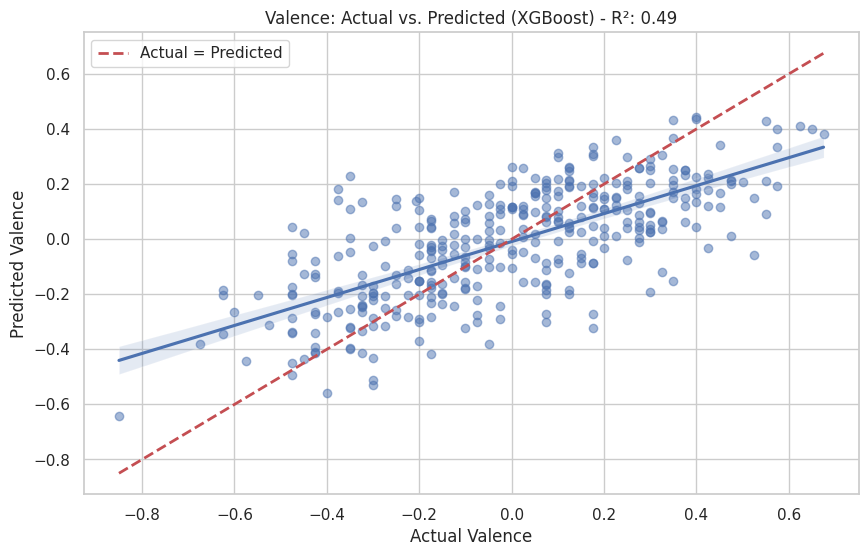

In [64]:
# Plot actual vs. predicted for valence
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test[:, 0], y=xgb_valence_pred, scatter_kws={'alpha':0.5})
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], [y_test[:, 0].min(), y_test[:, 0].max()], 'r--', lw=2, label='Actual = Predicted')
r2_xgb_valence = r2_score(y_test[:, 0], xgb_valence_pred)
plt.title(f'Valence: Actual vs. Predicted (XGBoost) - R²: {r2_xgb_valence:.2f}')
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.legend()
plt.show()

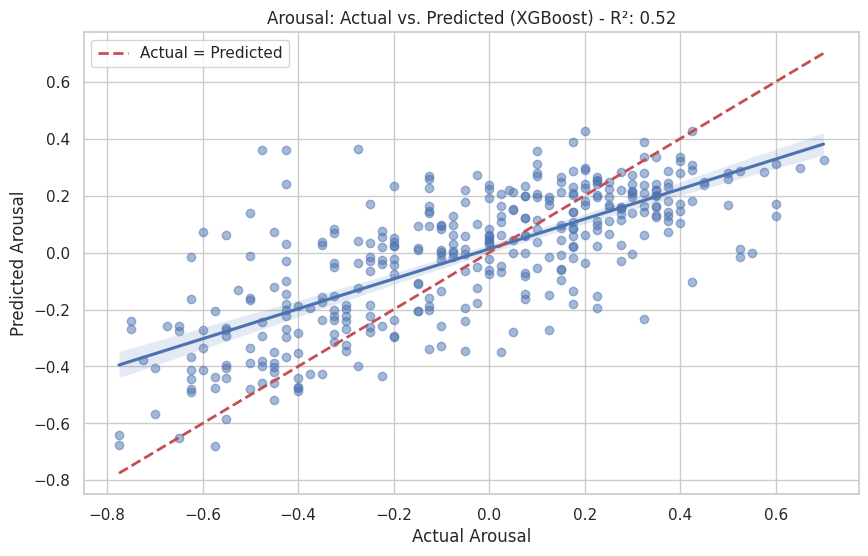

In [65]:
# Plot actual vs. predicted for arousal
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test[:, 1], y=xgb_arousal_pred, scatter_kws={'alpha':0.5})
plt.plot([y_test[:, 1].min(), y_test[:, 1].max()], [y_test[:, 1].min(), y_test[:, 1].max()], 'r--', lw=2, label='Actual = Predicted')
r2_xgb_arousal = r2_score(y_test[:, 1], xgb_arousal_pred)
plt.title(f'Arousal: Actual vs. Predicted (XGBoost) - R²: {r2_xgb_arousal:.2f}')
plt.xlabel('Actual Arousal')
plt.ylabel('Predicted Arousal')
plt.legend()
plt.show()

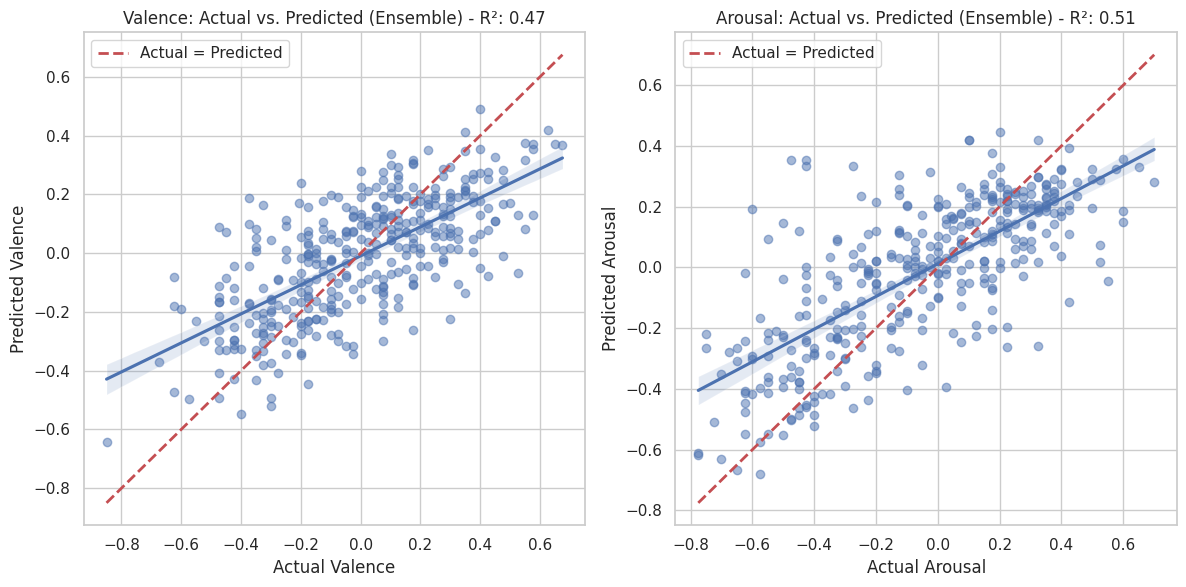

In [70]:
# Plot actual vs. predicted for both valence and arousal
plt.figure(figsize=(12, 6))

# Valence
plt.subplot(1, 2, 1)
sns.regplot(x=y_test[:, 0], y=ensemble_valence_pred, scatter_kws={'alpha':0.5})
plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], [y_test[:, 0].min(), y_test[:, 0].max()], 'r--', lw=2, label='Actual = Predicted')
r2_ensemble_valence = r2_score(y_test[:, 0], ensemble_valence_pred)
plt.title(f'Valence: Actual vs. Predicted (Ensemble) - R²: {r2_ensemble_valence:.2f}')
plt.xlabel('Actual Valence')
plt.ylabel('Predicted Valence')
plt.legend()

# Arousal
plt.subplot(1, 2, 2)
sns.regplot(x=y_test[:, 1], y=ensemble_arousal_pred, scatter_kws={'alpha':0.5})
plt.plot([y_test[:, 1].min(), y_test[:, 1].max()], [y_test[:, 1].min(), y_test[:, 1].max()], 'r--', lw=2, label='Actual = Predicted')
r2_ensemble_arousal = r2_score(y_test[:, 1], ensemble_arousal_pred)
plt.title(f'Arousal: Actual vs. Predicted (Ensemble) - R²: {r2_ensemble_arousal:.2f}')
plt.xlabel('Actual Arousal')
plt.ylabel('Predicted Arousal')
plt.legend()

plt.tight_layout()
plt.show()

In [71]:
# Create a comparison table of actual vs. predicted values for the ensemble model
import pandas as pd

# Create a sample of 15 random data points for visualization
np.random.seed(42)  # For reproducibility
sample_indices = np.random.choice(len(y_test), size=15, replace=False)

# Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual Valence': y_test[sample_indices, 0],
    'Predicted Valence': ensemble_valence_pred[sample_indices],
    'Valence Error': y_test[sample_indices, 0] - ensemble_valence_pred[sample_indices],
    'Actual Arousal': y_test[sample_indices, 1],
    'Predicted Arousal': ensemble_arousal_pred[sample_indices],
    'Arousal Error': y_test[sample_indices, 1] - ensemble_arousal_pred[sample_indices]
})

# Round to 3 decimal places for better readability
comparison_df = comparison_df.round(3)

# Add a column showing if prediction is within +/- 0.1 of actual value
comparison_df['Valence Within ±0.1'] = abs(comparison_df['Valence Error']) <= 0.1
comparison_df['Arousal Within ±0.1'] = abs(comparison_df['Arousal Error']) <= 0.1

# Display the table with styled formatting
from IPython.display import display, HTML

# Calculate overall accuracy statistics
valence_within_threshold = (abs(y_test[:, 0] - ensemble_valence_pred) <= 0.1).mean() * 100
arousal_within_threshold = (abs(y_test[:, 1] - ensemble_arousal_pred) <= 0.1).mean() * 100

# Display the sample comparison table with styled formatting
display(HTML(f"<h3>Ensemble Model: Actual vs. Predicted Values (Sample of {len(sample_indices)} Records)</h3>"))
display(comparison_df.style.set_properties(**{'text-align': 'center'})
        .applymap(lambda x: 'background-color: #C6EFCE' if x == True else 'background-color: #FFC7CE' if x == False else '', 
                  subset=['Valence Within ±0.1', 'Arousal Within ±0.1'])
        .format({'Valence Error': '{:.3f}', 'Arousal Error': '{:.3f}'}))

# Display overall accuracy statistics
print(f"\nOverall Accuracy Statistics (Entire Test Set, n={len(y_test)}):")
print(f"Valence predictions within ±0.1 of actual value: {valence_within_threshold:.1f}%")
print(f"Arousal predictions within ±0.1 of actual value: {arousal_within_threshold:.1f}%")
print(f"Average Valence Error: {np.mean(np.abs(y_test[:, 0] - ensemble_valence_pred)):.3f}")
print(f"Average Arousal Error: {np.mean(np.abs(y_test[:, 1] - ensemble_arousal_pred)):.3f}")

,Actual Valence,Predicted Valence,Valence Error,Actual Arousal,Predicted Arousal,Arousal Error,Valence Within ±0.1,Arousal Within ±0.1
0,0.425000,0.078000,0.347,0.350000,0.207000,0.143,False,False
1,0.100000,0.065000,0.035,0.150000,-0.051000,0.201,True,False
2,-0.025000,0.075000,-0.100,0.000000,0.022000,-0.022,True,True
3,0.275000,0.058000,0.217,-0.250000,-0.158000,-0.092,False,True
4,-0.300000,-0.156000,-0.144,0.225000,-0.197000,0.422,False,False
5,0.100000,0.046000,0.054,-0.125000,0.031000,-0.156,True,False
6,-0.075000,-0.274000,0.199,-0.375000,-0.416000,0.041,False,True
7,-0.450000,-0.084000,-0.366,-0.200000,-0.056000,-0.144,False,False
8,-0.325000,-0.305000,-0.020,-0.575000,-0.680000,0.105,True,False
9,0.325000,0.191000,0.134,0.225000,0.234000,-0.009,False,True



Overall Accuracy Statistics (Entire Test Set, n=361):
Valence predictions within ±0.1 of actual value: 35.2%
Arousal predictions within ±0.1 of actual value: 36.8%
Average Valence Error: 0.166
Average Arousal Error: 0.176
